In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader,TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import time

from thop import profile


In [2]:
# Remember to install CUDA and cuDNN
# Determine if your system supports CUDA.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#%% Read data
data=pd.read_hdf("D:/conda/FallAllD.h5") #
data = data.drop(columns = ['Gyr','Mag','Bar'])
#%% Label
data_waist = []
label_waist = []
subject_waist = []

for i in range(len(data)):
    if(data['Device'][i] == 'Waist'):
        a = data['Acc'][i]*0.000244
        # Normalize each data between 0 and 1
        b = b = (a-np.amin(a))/(np.amax(a)-np.amin(a)) 
        data_waist.append(b) 
        subject_waist.append(data['SubjectID'][i])
        # Class: fall = 0 ,ADL = 1 
        if (data['ActivityID'][i] > 100): 
            label_waist.append(1)
        else:
            label_waist.append(0)

# Change list to array
data_waist = np.array(data_waist)            
label_waist = np.array(label_waist)
subject_waist = np.array(subject_waist)

# Downsampling 1/128
down_data = []
# (start:size:step)
down_data = data_waist[::1,::128,::1]           
#%% Sliding_window
sliding_waist_data =[]
sliding_waist_label =[]
sliding_waist_subject =[]   

# The signal of each second 
per_sec = 38/20
sec = 7

In [3]:
for num in range(len(down_data)):
    if label_waist[num] ==1:
        # Data[index][start:end,axis]
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5)+1),:])
        # Label each window with class and subject
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        
    else:
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        
sliding_waist_data = np.array(sliding_waist_data)
sliding_waist_label = np.array(sliding_waist_label)
sliding_waist_subject = np.array(sliding_waist_subject) 

np.save('FallALLD_SW_data',sliding_waist_data)
np.save('FallALLD_SW_label',sliding_waist_label)
np.save('FallALLD_SW_subject',sliding_waist_subject)

In [4]:
#%% Show Teacher confusion matrix
def show_CM_teacher(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher) SubjectID' + str(sub) + '.png')

#%% Show Student confusion matrix
def show_CM_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Student) SubjectID' + str(sub) + '.png')
    
#%% Show Teacher-Student confusion matrix
def show_CM_teacher_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher-Student) SubjectID' + str(sub) + '.png')
#Loss_teacher
def show_loss_teacher(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher) SubjectID' + str(sub) + '.png')
def show_Acc_teacher(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher) SubjectID' + str(sub) + '.png')
#Loss_student
def show_loss_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (Student) SubjectID' + str(sub) + '.png')   
def show_Acc_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (student) SubjectID' + str(sub) + '.png')
def show_loss_teacher_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher_Student) SubjectID' + str(sub) + '.png')   
def show_Acc_teacher_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher_student) SubjectID' + str(sub) + '.png')

In [5]:
def loss_fn_kd(outputs, labels, teacher_outputs, T=20, alpha=0.5):
    # 一般的Cross Entropy
    labels=labels.type(torch.cuda.LongTensor)
    hard_loss = F.cross_entropy(outputs, labels) * (1. - alpha)
    # 讓logits的log_softmax對目標機率(teacher的logits/T後softmax)做KL Divergence。
    soft_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T)
    return hard_loss + soft_loss

In [6]:
#%% This is the config object which contains all relevant settings.    
config = {
    'nb_filters': 64,
    'filter_width': 1,
    'drop_prob': 0.5,
    'epochs': 200,#200
    'batch_size': 64,
    'learning_rate': 1e-3,#1e-3
    'weight_decay': 2e-6,
    'gpu_name': 'cuda:0',
    'print_counts': False,
    'lr_factor' : 2,
    'lr_warmup' : 40
}

In [7]:
#%% Define teacher neural network
class block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
      super(block, self).__init__()
      self.expansion = 4
      self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn1 = nn.BatchNorm2d(out_channels)
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1,bias=False)
      self.bn2 = nn.BatchNorm2d(out_channels)
      self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
      self.relu = nn.ReLU()
      self.identity_downsample = identity_downsample
      self.stride = stride

  def forward(self, x):
      identity = x.clone()
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.bn3(x)

      if self.identity_downsample is not None:
          identity = self.identity_downsample(identity)

      x += identity
      x = self.relu(x)
      return x

class Net_Teacher(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

#%% Define student neural network
class Net_Student(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Student, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        print("device:", device)
        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

#%% Define student neural network
class Net_Teacher_Student(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher_Student, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


In [8]:
#%% Define teacher training loop
def training_teacher(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []

        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        train_acc.append(100 * (correct_train / total_train).cpu())
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds, train_gt)

    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

#%% Define teacher testing loop
#def testing_teacher(testloader,optimizer,criterion,model):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)

                test_output = model(inputs)
                
                optimizer.zero_grad()

                # Compute loss
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step() 
                test_losses.append(loss.item())        
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)                

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher.append(eval_table[0])
#         Recall_teacher.append(eval_table[1])
#         Precision_teacher.append(eval_table[2])
#         F1score_teacher.append(eval_table[3])
    #Plot train_loss
        teacher_train_preds.extend(test_preds)
        teacher_train_gt.extend(test_gt)

    show_loss_teacher(loss_train, loss_test)
    show_Acc_teacher(train_acc, test_acc)
    #return Accuracy_teacher, Recall_teacher, Precision_teacher, F1score_teacher
    return teacher_train_preds, teacher_train_gt

In [9]:
#%% Define student training loop
def training_student(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(100 * (correct_train / total_train).cpu())
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval()
    #start_time = time.time()
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):            
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()                
                # Compute loss                

                test_output = model(inputs)
                
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step()
                test_losses.append(loss.item())                
                
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))
                
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
            elapsed = time.time() - start_time
            #print('| epoch {:3d} | {:5.4f} s/epoch | test loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))    
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nTest Val Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_student(test_gt, test_preds)
        #Store each result
#         Accuracy_student.append(eval_table[0])
#         Recall_student.append(eval_table[1])
#         Precision_student.append(eval_table[2])
#         F1score_student.append(eval_table[3])
        
        student_train_preds.extend(test_preds)
        student_train_gt.extend(test_gt)
    #Plot train_loss
    show_loss_student(loss_train, loss_test)
    show_Acc_student(train_acc, test_acc)
    
    #return Accuracy_student, Recall_student, Precision_student, F1score_student
    return student_train_preds, student_train_gt

In [10]:
def training_teacher_student(trainloader,optimizer,criterion,model_teacher,model_student,alpha,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    total_num, total_hit = 0, 0
    # Freeze the Teacher model
    model_teacher.eval()
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds_student = []
        train_preds_teacher = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()

            # Forward pass (compute output)
            output_student = model_student(inputs)
            output_teacher = model_teacher(inputs)

            # Use softmax to normalize the output to a probability distribution over predicted output classes
            output_student_soft = F.softmax(output_student, dim =1)
            y_preds_student = np.argmax(output_student_soft.cpu().detach().numpy(), axis=-1)

            output_teacher_soft = F.softmax(output_teacher, dim =1)
            y_preds_teacher = np.argmax(output_teacher_soft.cpu().detach().numpy(), axis=-1)

            # Compute loss
            loss = loss_fn_kd(output_student, labels, output_teacher, 20, alpha)
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            total_hit += torch.sum(torch.argmax(output_student, dim=1) == labels).item()
            total_num += len(inputs)
            y_true = labels.cpu().numpy().flatten()
            train_preds_student = np.concatenate((np.array(train_preds_student, int), np.array(y_preds_student, int)))
            train_preds_teacher = np.concatenate((np.array(train_preds_teacher, int), np.array(y_preds_teacher, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(total_hit/total_num)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds_student, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')
#%% Define Teacher-Student testing loop
#def testing_teacher_student(testloader,optimizer,criterion,model_teacher,model_student):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_num, total_hit = 0, 0
    # Sets network to eval mod
    model_teacher.eval()
    model_student.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):            
            for i, (x, y) in enumerate(testloader):
                inputs ,targets = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                targets = targets.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()
                
                test_output = model_student(inputs)
                test_teacher = model_teacher(inputs)
                # Compute loss
                #loss = loss_fn_kd(test_output, labels, output_teacher, 20, alpha)                
                loss = loss_fn_kd(test_output, targets, test_teacher, 20, alpha)                
                # Backpropagaton
                #loss.backward() 
                # Update parameter
                #optimizer.step() 
                test_losses.append(loss.item())     
                
                test_output = F.softmax(test_output, dim=1)                
                total_hit += torch.sum(torch.argmax(test_output, dim=1) == targets).item()
                total_num += len(inputs)
                
                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = targets.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            #eval_table = evaluation(test_preds,test_gt)
            test_acc.append(total_hit/total_num)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher_student(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher_student.append(eval_table[0])
#         Recall_teacher_student.append(eval_table[1])
#         Precision_teacher_student.append(eval_table[2])
#         F1score_teacher_student.append(eval_table[3])      
        teacher_student_train_preds.extend(test_preds)
        teacher_student_train_gt.extend(test_gt)
    show_loss_teacher_student(loss_train, loss_test)
    show_Acc_teacher_student(train_acc,test_acc)
    #return Accuracy_teacher_student, Recall_teacher_student, Precision_teacher_student, F1score_teacher_student
    return teacher_student_train_preds, teacher_student_train_gt


Subject 1
device: cuda
| epoch   0 | 0.3949 s/epoch | train loss 0.4715
| epoch   1 | 0.3169 s/epoch | train loss 0.3518
| epoch   2 | 0.3167 s/epoch | train loss 0.3472
| epoch   3 | 0.3142 s/epoch | train loss 0.3277
| epoch   4 | 0.3172 s/epoch | train loss 0.2983
| epoch   5 | 0.3169 s/epoch | train loss 0.2921
| epoch   6 | 0.3161 s/epoch | train loss 0.3189
| epoch   7 | 0.3153 s/epoch | train loss 0.3234
| epoch   8 | 0.3162 s/epoch | train loss 0.3362
| epoch   9 | 0.3127 s/epoch | train loss 0.3394
| epoch  10 | 0.2715 s/epoch | train loss 0.3125
| epoch  11 | 0.2744 s/epoch | train loss 0.2785
| epoch  12 | 0.2718 s/epoch | train loss 0.2677
| epoch  13 | 0.2760 s/epoch | train loss 0.2685
| epoch  14 | 0.2712 s/epoch | train loss 0.2586
| epoch  15 | 0.2721 s/epoch | train loss 0.2628
| epoch  16 | 0.2736 s/epoch | train loss 0.2440
| epoch  17 | 0.2724 s/epoch | train loss 0.2327
| epoch  18 | 0.2718 s/epoch | train loss 0.2396
| epoch  19 | 0.2712 s/epoch | train loss 0.2

| epoch 167 | 0.2749 s/epoch | train loss 0.0519
| epoch 168 | 0.2799 s/epoch | train loss 0.0574
| epoch 169 | 0.2574 s/epoch | train loss 0.0599
| epoch 170 | 0.2529 s/epoch | train loss 0.0480
| epoch 171 | 0.2491 s/epoch | train loss 0.0475
| epoch 172 | 0.2394 s/epoch | train loss 0.0438
| epoch 173 | 0.2371 s/epoch | train loss 0.0486
| epoch 174 | 0.2406 s/epoch | train loss 0.0658
| epoch 175 | 0.2394 s/epoch | train loss 0.0463
| epoch 176 | 0.2379 s/epoch | train loss 0.0704
| epoch 177 | 0.2412 s/epoch | train loss 0.0407
| epoch 178 | 0.2368 s/epoch | train loss 0.0463
| epoch 179 | 0.2352 s/epoch | train loss 0.0490
| epoch 180 | 0.2384 s/epoch | train loss 0.0474
| epoch 181 | 0.2364 s/epoch | train loss 0.1252
| epoch 182 | 0.2394 s/epoch | train loss 0.0527
| epoch 183 | 0.2371 s/epoch | train loss 0.0646
| epoch 184 | 0.2585 s/epoch | train loss 0.0319
| epoch 185 | 0.2602 s/epoch | train loss 0.0404
| epoch 186 | 0.2610 s/epoch | train loss 0.0509
| epoch 187 | 0.2605

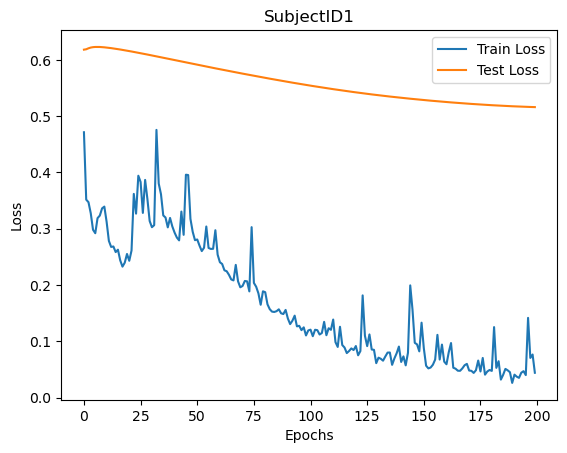

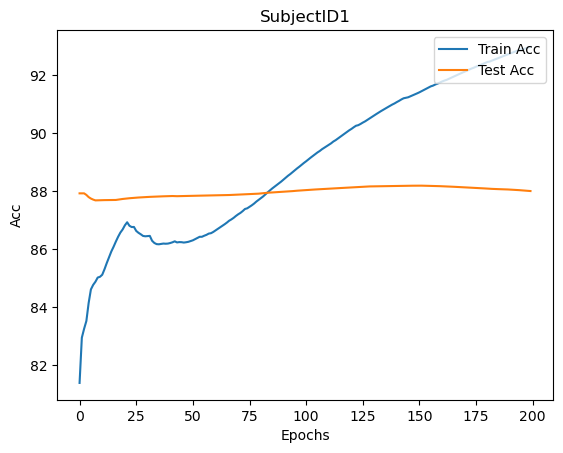

| epoch   0 | 0.2734 s/epoch | train loss 0.4206
| epoch   1 | 0.2718 s/epoch | train loss 0.3372
| epoch   2 | 0.2712 s/epoch | train loss 0.3414
| epoch   3 | 0.2708 s/epoch | train loss 0.3207
| epoch   4 | 0.2706 s/epoch | train loss 0.3087
| epoch   5 | 0.2676 s/epoch | train loss 0.4687
| epoch   6 | 0.2718 s/epoch | train loss 0.3354
| epoch   7 | 0.2693 s/epoch | train loss 0.3270
| epoch   8 | 0.2711 s/epoch | train loss 0.3053
| epoch   9 | 0.2675 s/epoch | train loss 0.3040
| epoch  10 | 0.2702 s/epoch | train loss 0.2941
| epoch  11 | 0.2705 s/epoch | train loss 0.2857
| epoch  12 | 0.2716 s/epoch | train loss 0.2819
| epoch  13 | 0.2702 s/epoch | train loss 0.2612
| epoch  14 | 0.2707 s/epoch | train loss 0.2491
| epoch  15 | 0.2741 s/epoch | train loss 0.2701
| epoch  16 | 0.2729 s/epoch | train loss 0.2855
| epoch  17 | 0.2734 s/epoch | train loss 0.2446
| epoch  18 | 0.2721 s/epoch | train loss 0.2415
| epoch  19 | 0.2712 s/epoch | train loss 0.2278
| epoch  20 | 0.2723

| epoch 168 | 0.2718 s/epoch | train loss 0.0411
| epoch 169 | 0.2719 s/epoch | train loss 0.0503
| epoch 170 | 0.2720 s/epoch | train loss 0.0426
| epoch 171 | 0.2762 s/epoch | train loss 0.0439
| epoch 172 | 0.2705 s/epoch | train loss 0.0398
| epoch 173 | 0.2705 s/epoch | train loss 0.0346
| epoch 174 | 0.2703 s/epoch | train loss 0.0446
| epoch 175 | 0.2737 s/epoch | train loss 0.0462
| epoch 176 | 0.2727 s/epoch | train loss 0.0930
| epoch 177 | 0.2722 s/epoch | train loss 0.0646
| epoch 178 | 0.2705 s/epoch | train loss 0.0316
| epoch 179 | 0.2695 s/epoch | train loss 0.0460
| epoch 180 | 0.2732 s/epoch | train loss 0.1088
| epoch 181 | 0.2726 s/epoch | train loss 0.0482
| epoch 182 | 0.2755 s/epoch | train loss 0.1176
| epoch 183 | 0.2699 s/epoch | train loss 0.0520
| epoch 184 | 0.2714 s/epoch | train loss 0.0411
| epoch 185 | 0.2710 s/epoch | train loss 0.0351
| epoch 186 | 0.2680 s/epoch | train loss 0.0538
| epoch 187 | 0.2728 s/epoch | train loss 0.0368
| epoch 188 | 0.2721

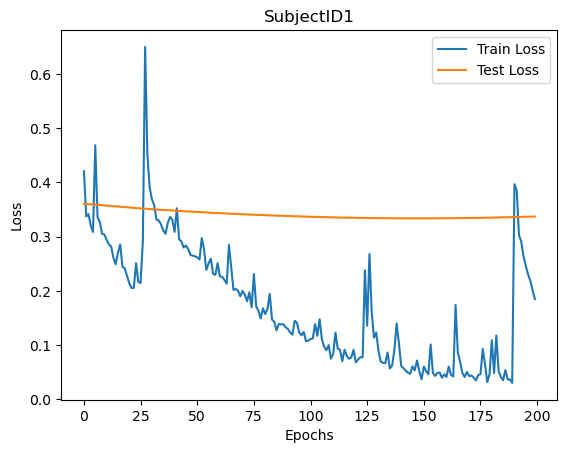

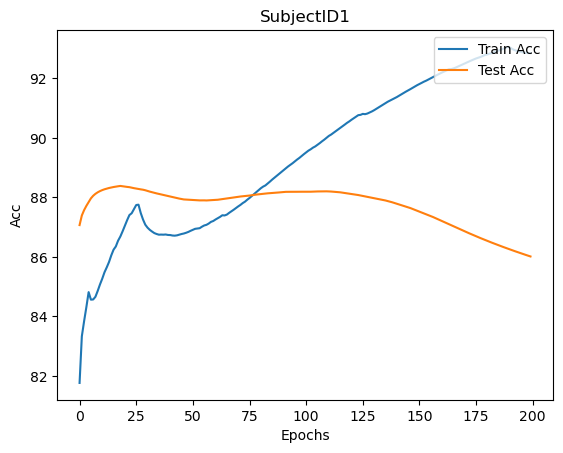


Subject 2
device: cuda
| epoch   0 | 0.2553 s/epoch | train loss 0.4794
| epoch   1 | 0.2471 s/epoch | train loss 0.4800
| epoch   2 | 0.2457 s/epoch | train loss 0.4370
| epoch   3 | 0.2461 s/epoch | train loss 0.3462
| epoch   4 | 0.2449 s/epoch | train loss 0.3424
| epoch   5 | 0.2488 s/epoch | train loss 0.4023
| epoch   6 | 0.2467 s/epoch | train loss 0.3716
| epoch   7 | 0.2448 s/epoch | train loss 0.3638
| epoch   8 | 0.2460 s/epoch | train loss 0.3783
| epoch   9 | 0.2466 s/epoch | train loss 0.4434
| epoch  10 | 0.2461 s/epoch | train loss 0.3746
| epoch  11 | 0.2455 s/epoch | train loss 0.3608
| epoch  12 | 0.2472 s/epoch | train loss 0.3317
| epoch  13 | 0.2331 s/epoch | train loss 0.3377
| epoch  14 | 0.2308 s/epoch | train loss 0.3168
| epoch  15 | 0.2367 s/epoch | train loss 0.3286
| epoch  16 | 0.2516 s/epoch | train loss 0.3601
| epoch  17 | 0.2527 s/epoch | train loss 0.3374
| epoch  18 | 0.2512 s/epoch | train loss 0.3001
| epoch  19 | 0.2506 s/epoch | train loss 0.3

| epoch 167 | 0.2647 s/epoch | train loss 0.0985
| epoch 168 | 0.2627 s/epoch | train loss 0.2135
| epoch 169 | 0.2638 s/epoch | train loss 0.1308
| epoch 170 | 0.2649 s/epoch | train loss 0.1104
| epoch 171 | 0.2650 s/epoch | train loss 0.1117
| epoch 172 | 0.2656 s/epoch | train loss 0.0945
| epoch 173 | 0.2642 s/epoch | train loss 0.1364
| epoch 174 | 0.2611 s/epoch | train loss 0.2377
| epoch 175 | 0.2657 s/epoch | train loss 0.1515
| epoch 176 | 0.2631 s/epoch | train loss 0.1228
| epoch 177 | 0.2651 s/epoch | train loss 0.1231
| epoch 178 | 0.2655 s/epoch | train loss 0.1108
| epoch 179 | 0.2640 s/epoch | train loss 0.0895
| epoch 180 | 0.2635 s/epoch | train loss 0.1882
| epoch 181 | 0.2628 s/epoch | train loss 0.2141
| epoch 182 | 0.2632 s/epoch | train loss 0.1217
| epoch 183 | 0.2631 s/epoch | train loss 0.0934
| epoch 184 | 0.2648 s/epoch | train loss 0.0963
| epoch 185 | 0.2640 s/epoch | train loss 0.0943
| epoch 186 | 0.2630 s/epoch | train loss 0.0921
| epoch 187 | 0.2643

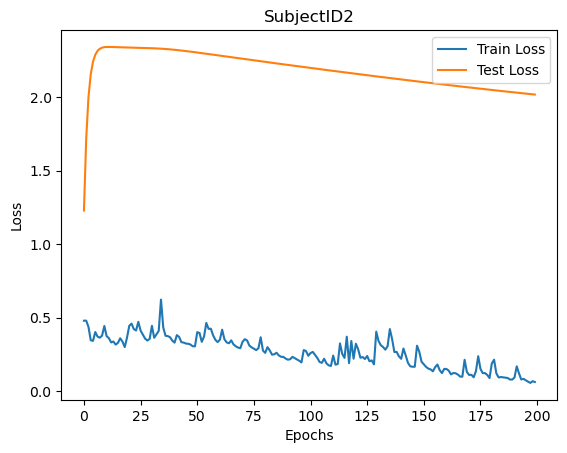

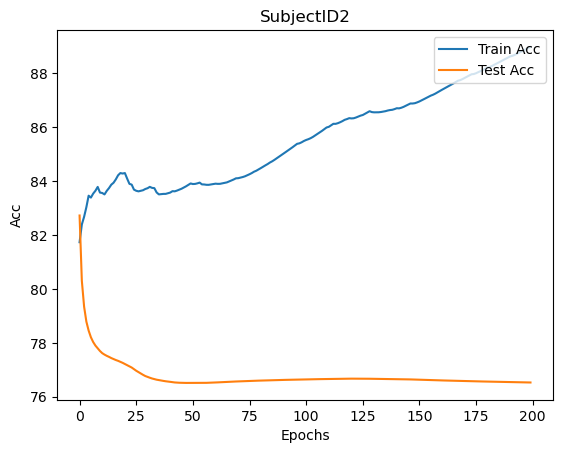

| epoch   0 | 0.2620 s/epoch | train loss 0.4629
| epoch   1 | 0.2646 s/epoch | train loss 0.4809
| epoch   2 | 0.2616 s/epoch | train loss 0.4389
| epoch   3 | 0.2642 s/epoch | train loss 0.3716
| epoch   4 | 0.2632 s/epoch | train loss 0.3392
| epoch   5 | 0.2613 s/epoch | train loss 0.3179
| epoch   6 | 0.2618 s/epoch | train loss 0.3118
| epoch   7 | 0.2631 s/epoch | train loss 0.3146
| epoch   8 | 0.2622 s/epoch | train loss 0.4306
| epoch   9 | 0.2634 s/epoch | train loss 0.4528
| epoch  10 | 0.2624 s/epoch | train loss 0.3220
| epoch  11 | 0.2643 s/epoch | train loss 0.3452
| epoch  12 | 0.2630 s/epoch | train loss 0.3625
| epoch  13 | 0.2638 s/epoch | train loss 0.3032
| epoch  14 | 0.2640 s/epoch | train loss 0.3065
| epoch  15 | 0.2608 s/epoch | train loss 0.2673
| epoch  16 | 0.2657 s/epoch | train loss 0.2878
| epoch  17 | 0.2661 s/epoch | train loss 0.3007
| epoch  18 | 0.2626 s/epoch | train loss 0.3015
| epoch  19 | 0.2636 s/epoch | train loss 0.2616
| epoch  20 | 0.2649

| epoch 168 | 0.2696 s/epoch | train loss 0.1093
| epoch 169 | 0.2682 s/epoch | train loss 0.1565
| epoch 170 | 0.2666 s/epoch | train loss 0.1256
| epoch 171 | 0.2491 s/epoch | train loss 0.1153
| epoch 172 | 0.2456 s/epoch | train loss 0.1817
| epoch 173 | 0.2456 s/epoch | train loss 0.1383
| epoch 174 | 0.2470 s/epoch | train loss 0.1147
| epoch 175 | 0.2481 s/epoch | train loss 0.1117
| epoch 176 | 0.2458 s/epoch | train loss 0.1006
| epoch 177 | 0.2468 s/epoch | train loss 0.1085
| epoch 178 | 0.2440 s/epoch | train loss 0.1059
| epoch 179 | 0.2462 s/epoch | train loss 0.1016
| epoch 180 | 0.2460 s/epoch | train loss 0.0996
| epoch 181 | 0.2460 s/epoch | train loss 0.1386
| epoch 182 | 0.2453 s/epoch | train loss 0.4231
| epoch 183 | 0.2425 s/epoch | train loss 0.3811
| epoch 184 | 0.2462 s/epoch | train loss 0.3537
| epoch 185 | 0.2456 s/epoch | train loss 0.3487
| epoch 186 | 0.2597 s/epoch | train loss 0.3592
| epoch 187 | 0.2631 s/epoch | train loss 0.3223
| epoch 188 | 0.2618

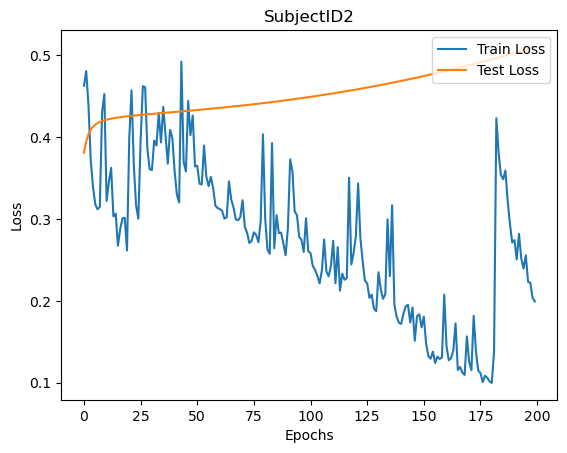

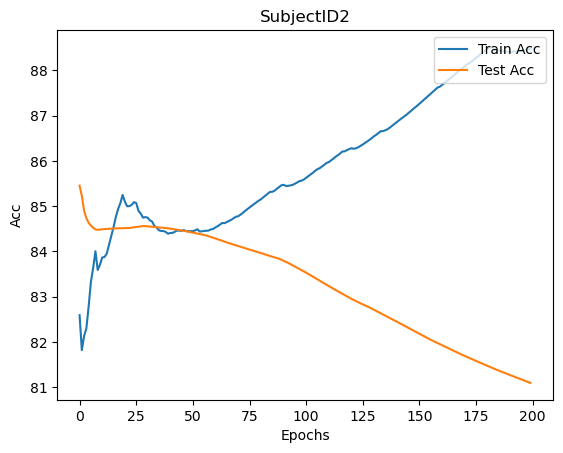


Subject 3
device: cuda
| epoch   0 | 0.2514 s/epoch | train loss 0.5196
| epoch   1 | 0.2490 s/epoch | train loss 0.3769
| epoch   2 | 0.2504 s/epoch | train loss 0.3228
| epoch   3 | 0.2524 s/epoch | train loss 0.2806
| epoch   4 | 0.2515 s/epoch | train loss 0.2773
| epoch   5 | 0.2506 s/epoch | train loss 0.2719
| epoch   6 | 0.2583 s/epoch | train loss 0.2663
| epoch   7 | 0.2640 s/epoch | train loss 0.2587
| epoch   8 | 0.2620 s/epoch | train loss 0.2464
| epoch   9 | 0.2652 s/epoch | train loss 0.2468
| epoch  10 | 0.2638 s/epoch | train loss 0.2340
| epoch  11 | 0.2648 s/epoch | train loss 0.2298
| epoch  12 | 0.2639 s/epoch | train loss 0.2110
| epoch  13 | 0.2673 s/epoch | train loss 0.2112
| epoch  14 | 0.2624 s/epoch | train loss 0.2066
| epoch  15 | 0.2645 s/epoch | train loss 0.3157
| epoch  16 | 0.2619 s/epoch | train loss 0.3204
| epoch  17 | 0.2630 s/epoch | train loss 0.3117
| epoch  18 | 0.2634 s/epoch | train loss 0.2973
| epoch  19 | 0.2605 s/epoch | train loss 0.2

| epoch 167 | 0.2643 s/epoch | train loss 0.0360
| epoch 168 | 0.2648 s/epoch | train loss 0.0300
| epoch 169 | 0.2658 s/epoch | train loss 0.0484
| epoch 170 | 0.2611 s/epoch | train loss 0.0274
| epoch 171 | 0.2651 s/epoch | train loss 0.0262
| epoch 172 | 0.2641 s/epoch | train loss 0.0349
| epoch 173 | 0.2668 s/epoch | train loss 0.0423
| epoch 174 | 0.2639 s/epoch | train loss 0.0386
| epoch 175 | 0.2642 s/epoch | train loss 0.0269
| epoch 176 | 0.2601 s/epoch | train loss 0.0291
| epoch 177 | 0.2655 s/epoch | train loss 0.0295
| epoch 178 | 0.2664 s/epoch | train loss 0.0336
| epoch 179 | 0.2653 s/epoch | train loss 0.1741
| epoch 180 | 0.2652 s/epoch | train loss 0.0910
| epoch 181 | 0.2642 s/epoch | train loss 0.2912
| epoch 182 | 0.2659 s/epoch | train loss 0.2314
| epoch 183 | 0.2634 s/epoch | train loss 0.1693
| epoch 184 | 0.2626 s/epoch | train loss 0.1244
| epoch 185 | 0.2648 s/epoch | train loss 0.0850
| epoch 186 | 0.2655 s/epoch | train loss 0.0613
| epoch 187 | 0.2637

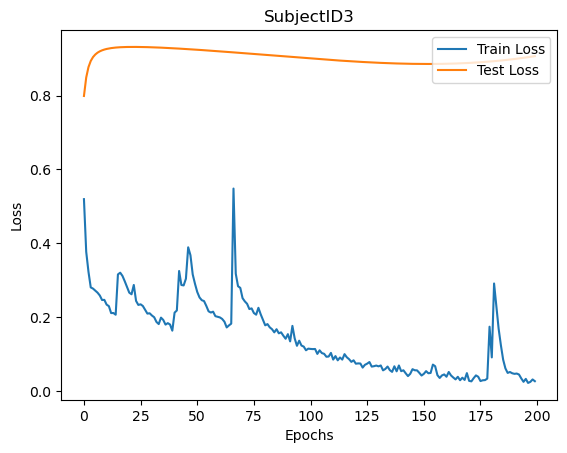

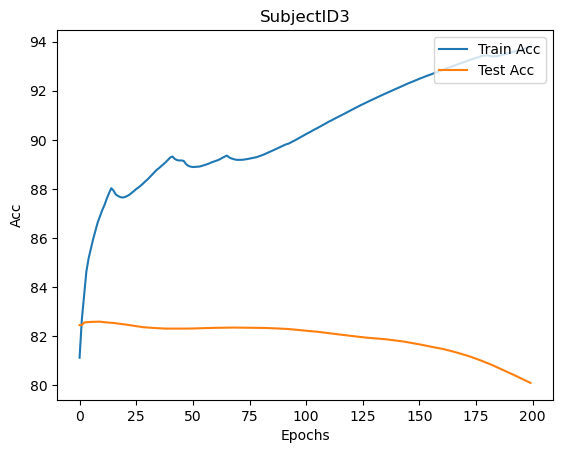

| epoch   0 | 0.2668 s/epoch | train loss 0.4755
| epoch   1 | 0.2653 s/epoch | train loss 0.3982
| epoch   2 | 0.2449 s/epoch | train loss 0.3320
| epoch   3 | 0.2462 s/epoch | train loss 0.3119
| epoch   4 | 0.2484 s/epoch | train loss 0.2862
| epoch   5 | 0.2466 s/epoch | train loss 0.3141
| epoch   6 | 0.2466 s/epoch | train loss 0.2777
| epoch   7 | 0.2470 s/epoch | train loss 0.2709
| epoch   8 | 0.2461 s/epoch | train loss 0.2659
| epoch   9 | 0.2472 s/epoch | train loss 0.2976
| epoch  10 | 0.2471 s/epoch | train loss 0.3422
| epoch  11 | 0.2472 s/epoch | train loss 0.3008
| epoch  12 | 0.2455 s/epoch | train loss 0.2780
| epoch  13 | 0.2489 s/epoch | train loss 0.2571
| epoch  14 | 0.2448 s/epoch | train loss 0.2550
| epoch  15 | 0.2459 s/epoch | train loss 0.2508
| epoch  16 | 0.2399 s/epoch | train loss 0.2343
| epoch  17 | 0.2118 s/epoch | train loss 0.2233
| epoch  18 | 0.2619 s/epoch | train loss 0.2213
| epoch  19 | 0.2641 s/epoch | train loss 0.2125
| epoch  20 | 0.2647

| epoch 168 | 0.2649 s/epoch | train loss 0.0762
| epoch 169 | 0.2688 s/epoch | train loss 0.0602
| epoch 170 | 0.2675 s/epoch | train loss 0.0747
| epoch 171 | 0.2645 s/epoch | train loss 0.0554
| epoch 172 | 0.2486 s/epoch | train loss 0.0506
| epoch 173 | 0.2525 s/epoch | train loss 0.0494
| epoch 174 | 0.2506 s/epoch | train loss 0.0481
| epoch 175 | 0.2508 s/epoch | train loss 0.0791
| epoch 176 | 0.2489 s/epoch | train loss 0.0464
| epoch 177 | 0.2506 s/epoch | train loss 0.0490
| epoch 178 | 0.2498 s/epoch | train loss 0.0441
| epoch 179 | 0.2490 s/epoch | train loss 0.0415
| epoch 180 | 0.2483 s/epoch | train loss 0.0362
| epoch 181 | 0.2498 s/epoch | train loss 0.0502
| epoch 182 | 0.2507 s/epoch | train loss 0.0448
| epoch 183 | 0.2504 s/epoch | train loss 0.0565
| epoch 184 | 0.2470 s/epoch | train loss 0.0465
| epoch 185 | 0.2502 s/epoch | train loss 0.0522
| epoch 186 | 0.2514 s/epoch | train loss 0.0451
| epoch 187 | 0.2481 s/epoch | train loss 0.0348
| epoch 188 | 0.2493

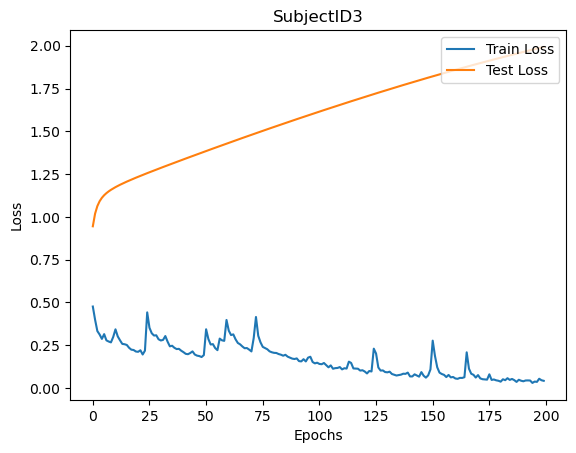

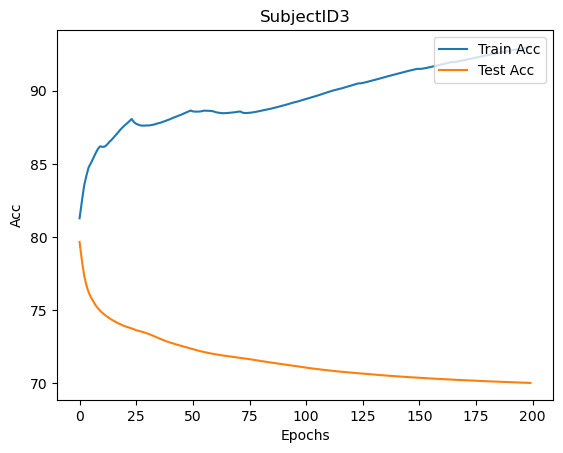


Subject 4
device: cuda
| epoch   0 | 0.2785 s/epoch | train loss 0.4566
| epoch   1 | 0.2761 s/epoch | train loss 0.3560
| epoch   2 | 0.2771 s/epoch | train loss 0.3370
| epoch   3 | 0.2788 s/epoch | train loss 0.3270
| epoch   4 | 0.2775 s/epoch | train loss 0.2975
| epoch   5 | 0.2766 s/epoch | train loss 0.2904
| epoch   6 | 0.2803 s/epoch | train loss 0.2878
| epoch   7 | 0.2818 s/epoch | train loss 0.2752
| epoch   8 | 0.2779 s/epoch | train loss 0.2518
| epoch   9 | 0.2784 s/epoch | train loss 0.2534
| epoch  10 | 0.2790 s/epoch | train loss 0.2541
| epoch  11 | 0.2810 s/epoch | train loss 0.2463
| epoch  12 | 0.2786 s/epoch | train loss 0.2320
| epoch  13 | 0.2808 s/epoch | train loss 0.2418
| epoch  14 | 0.2807 s/epoch | train loss 0.2330
| epoch  15 | 0.2800 s/epoch | train loss 0.2238
| epoch  16 | 0.2788 s/epoch | train loss 0.2249
| epoch  17 | 0.2812 s/epoch | train loss 0.2119
| epoch  18 | 0.2781 s/epoch | train loss 0.2216
| epoch  19 | 0.2817 s/epoch | train loss 0.2

| epoch 167 | 0.2815 s/epoch | train loss 0.0465
| epoch 168 | 0.2784 s/epoch | train loss 0.0445
| epoch 169 | 0.2819 s/epoch | train loss 0.0525
| epoch 170 | 0.2796 s/epoch | train loss 0.0432
| epoch 171 | 0.2787 s/epoch | train loss 0.0360
| epoch 172 | 0.2817 s/epoch | train loss 0.0361
| epoch 173 | 0.2800 s/epoch | train loss 0.0520
| epoch 174 | 0.2817 s/epoch | train loss 0.1094
| epoch 175 | 0.2810 s/epoch | train loss 0.0491
| epoch 176 | 0.2830 s/epoch | train loss 0.0347
| epoch 177 | 0.2798 s/epoch | train loss 0.0391
| epoch 178 | 0.2789 s/epoch | train loss 0.0332
| epoch 179 | 0.2803 s/epoch | train loss 0.0451
| epoch 180 | 0.2829 s/epoch | train loss 0.0336
| epoch 181 | 0.2832 s/epoch | train loss 0.0447
| epoch 182 | 0.2826 s/epoch | train loss 0.0355
| epoch 183 | 0.2805 s/epoch | train loss 0.0509
| epoch 184 | 0.2807 s/epoch | train loss 0.0385
| epoch 185 | 0.2799 s/epoch | train loss 0.0357
| epoch 186 | 0.2790 s/epoch | train loss 0.0270
| epoch 187 | 0.2830

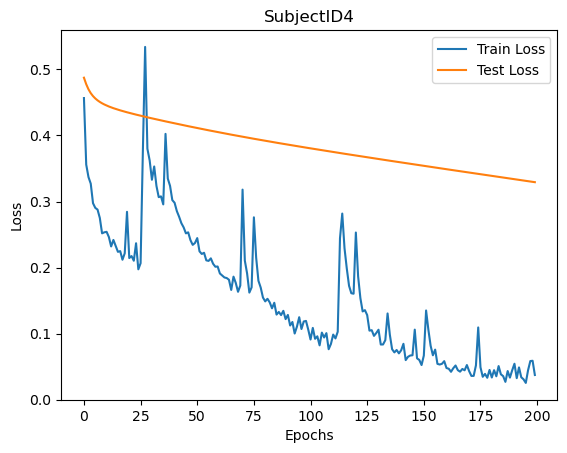

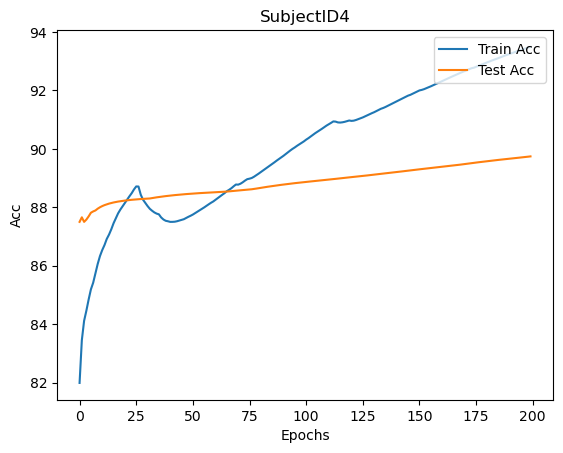

| epoch   0 | 0.2825 s/epoch | train loss 0.4903
| epoch   1 | 0.2777 s/epoch | train loss 0.3449
| epoch   2 | 0.2801 s/epoch | train loss 0.3209
| epoch   3 | 0.2786 s/epoch | train loss 0.2938
| epoch   4 | 0.2772 s/epoch | train loss 0.2952
| epoch   5 | 0.2791 s/epoch | train loss 0.2652
| epoch   6 | 0.2810 s/epoch | train loss 0.2641
| epoch   7 | 0.2778 s/epoch | train loss 0.2616
| epoch   8 | 0.2825 s/epoch | train loss 0.2566
| epoch   9 | 0.2773 s/epoch | train loss 0.2692
| epoch  10 | 0.2769 s/epoch | train loss 0.2481
| epoch  11 | 0.2792 s/epoch | train loss 0.2332
| epoch  12 | 0.2770 s/epoch | train loss 0.2403
| epoch  13 | 0.2781 s/epoch | train loss 0.3906
| epoch  14 | 0.2768 s/epoch | train loss 0.3513
| epoch  15 | 0.2787 s/epoch | train loss 0.3242
| epoch  16 | 0.2803 s/epoch | train loss 0.3319
| epoch  17 | 0.2791 s/epoch | train loss 0.3086
| epoch  18 | 0.2781 s/epoch | train loss 0.2947
| epoch  19 | 0.2782 s/epoch | train loss 0.2911
| epoch  20 | 0.2787

| epoch 168 | 0.2806 s/epoch | train loss 0.0369
| epoch 169 | 0.2795 s/epoch | train loss 0.0335
| epoch 170 | 0.2797 s/epoch | train loss 0.0365
| epoch 171 | 0.2787 s/epoch | train loss 0.0355
| epoch 172 | 0.2762 s/epoch | train loss 0.0358
| epoch 173 | 0.2728 s/epoch | train loss 0.0384
| epoch 174 | 0.2797 s/epoch | train loss 0.0355
| epoch 175 | 0.2786 s/epoch | train loss 0.0321
| epoch 176 | 0.2802 s/epoch | train loss 0.0406
| epoch 177 | 0.2799 s/epoch | train loss 0.0272
| epoch 178 | 0.2801 s/epoch | train loss 0.0312
| epoch 179 | 0.2809 s/epoch | train loss 0.0448
| epoch 180 | 0.2795 s/epoch | train loss 0.1526
| epoch 181 | 0.2817 s/epoch | train loss 0.0651
| epoch 182 | 0.2808 s/epoch | train loss 0.0538
| epoch 183 | 0.2829 s/epoch | train loss 0.0337
| epoch 184 | 0.2818 s/epoch | train loss 0.0253
| epoch 185 | 0.2812 s/epoch | train loss 0.0244
| epoch 186 | 0.2828 s/epoch | train loss 0.0302
| epoch 187 | 0.2807 s/epoch | train loss 0.0367
| epoch 188 | 0.2810

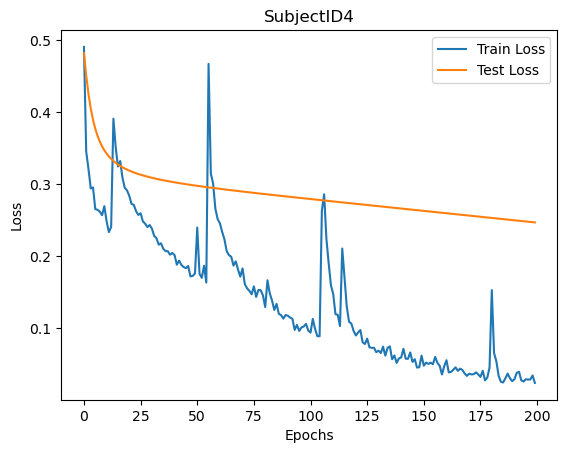

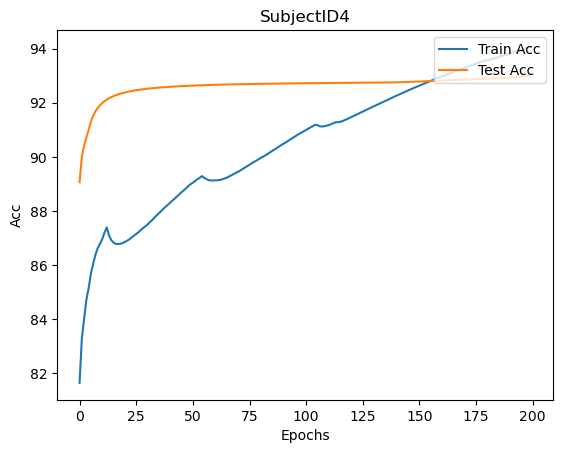


Subject 5
device: cuda
| epoch   0 | 0.2646 s/epoch | train loss 0.4661
| epoch   1 | 0.2664 s/epoch | train loss 0.3457
| epoch   2 | 0.2582 s/epoch | train loss 0.3414
| epoch   3 | 0.2675 s/epoch | train loss 0.3405
| epoch   4 | 0.2688 s/epoch | train loss 0.3204
| epoch   5 | 0.2687 s/epoch | train loss 0.2972
| epoch   6 | 0.2676 s/epoch | train loss 0.2796
| epoch   7 | 0.2677 s/epoch | train loss 0.2704
| epoch   8 | 0.2674 s/epoch | train loss 0.2589
| epoch   9 | 0.2666 s/epoch | train loss 0.2620
| epoch  10 | 0.2675 s/epoch | train loss 0.2673
| epoch  11 | 0.2673 s/epoch | train loss 0.2468
| epoch  12 | 0.2662 s/epoch | train loss 0.2323
| epoch  13 | 0.2616 s/epoch | train loss 0.2386
| epoch  14 | 0.2637 s/epoch | train loss 0.2281
| epoch  15 | 0.2682 s/epoch | train loss 0.2181
| epoch  16 | 0.2657 s/epoch | train loss 0.2203
| epoch  17 | 0.2666 s/epoch | train loss 0.2112
| epoch  18 | 0.2691 s/epoch | train loss 0.2192
| epoch  19 | 0.2695 s/epoch | train loss 0.2

| epoch 167 | 0.2686 s/epoch | train loss 0.0818
| epoch 168 | 0.2707 s/epoch | train loss 0.0909
| epoch 169 | 0.2682 s/epoch | train loss 0.0783
| epoch 170 | 0.2683 s/epoch | train loss 0.2252
| epoch 171 | 0.2673 s/epoch | train loss 0.2173
| epoch 172 | 0.2668 s/epoch | train loss 0.1562
| epoch 173 | 0.2688 s/epoch | train loss 0.1217
| epoch 174 | 0.2658 s/epoch | train loss 0.1002
| epoch 175 | 0.2680 s/epoch | train loss 0.0943
| epoch 176 | 0.2664 s/epoch | train loss 0.0903
| epoch 177 | 0.2684 s/epoch | train loss 0.0759
| epoch 178 | 0.2691 s/epoch | train loss 0.0742
| epoch 179 | 0.2702 s/epoch | train loss 0.0735
| epoch 180 | 0.2702 s/epoch | train loss 0.0675
| epoch 181 | 0.2685 s/epoch | train loss 0.0641
| epoch 182 | 0.2703 s/epoch | train loss 0.0727
| epoch 183 | 0.2684 s/epoch | train loss 0.0682
| epoch 184 | 0.2666 s/epoch | train loss 0.0596
| epoch 185 | 0.2666 s/epoch | train loss 0.0672
| epoch 186 | 0.2684 s/epoch | train loss 0.0508
| epoch 187 | 0.2695

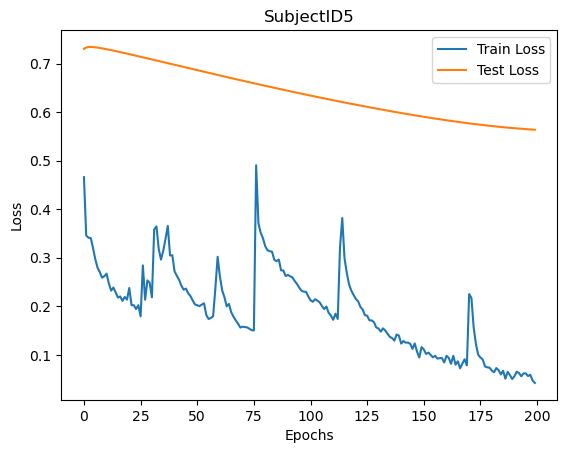

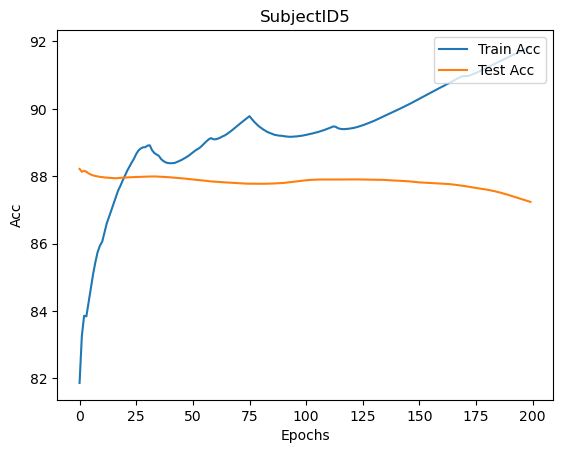

| epoch   0 | 0.2675 s/epoch | train loss 0.4890
| epoch   1 | 0.2676 s/epoch | train loss 0.3534
| epoch   2 | 0.2696 s/epoch | train loss 0.3193
| epoch   3 | 0.2656 s/epoch | train loss 0.3812
| epoch   4 | 0.2689 s/epoch | train loss 0.3756
| epoch   5 | 0.2666 s/epoch | train loss 0.3647
| epoch   6 | 0.2690 s/epoch | train loss 0.3175
| epoch   7 | 0.2655 s/epoch | train loss 0.2936
| epoch   8 | 0.2674 s/epoch | train loss 0.2688
| epoch   9 | 0.2637 s/epoch | train loss 0.2763
| epoch  10 | 0.2676 s/epoch | train loss 0.2684
| epoch  11 | 0.2658 s/epoch | train loss 0.2485
| epoch  12 | 0.2682 s/epoch | train loss 0.2405
| epoch  13 | 0.2654 s/epoch | train loss 0.2348
| epoch  14 | 0.2644 s/epoch | train loss 0.2311
| epoch  15 | 0.2653 s/epoch | train loss 0.2246
| epoch  16 | 0.2674 s/epoch | train loss 0.2256
| epoch  17 | 0.2682 s/epoch | train loss 0.2162
| epoch  18 | 0.2675 s/epoch | train loss 0.2124
| epoch  19 | 0.2665 s/epoch | train loss 0.2077
| epoch  20 | 0.2654

| epoch 168 | 0.2658 s/epoch | train loss 0.0475
| epoch 169 | 0.2637 s/epoch | train loss 0.0416
| epoch 170 | 0.2659 s/epoch | train loss 0.0488
| epoch 171 | 0.2681 s/epoch | train loss 0.0528
| epoch 172 | 0.2676 s/epoch | train loss 0.0454
| epoch 173 | 0.2659 s/epoch | train loss 0.0429
| epoch 174 | 0.2673 s/epoch | train loss 0.0562
| epoch 175 | 0.2685 s/epoch | train loss 0.0562
| epoch 176 | 0.2687 s/epoch | train loss 0.0432
| epoch 177 | 0.2665 s/epoch | train loss 0.0536
| epoch 178 | 0.2670 s/epoch | train loss 0.0411
| epoch 179 | 0.2674 s/epoch | train loss 0.0398
| epoch 180 | 0.2695 s/epoch | train loss 0.0393
| epoch 181 | 0.2647 s/epoch | train loss 0.0402
| epoch 182 | 0.2637 s/epoch | train loss 0.0349
| epoch 183 | 0.2675 s/epoch | train loss 0.0328
| epoch 184 | 0.2663 s/epoch | train loss 0.0356
| epoch 185 | 0.2691 s/epoch | train loss 0.0487
| epoch 186 | 0.2684 s/epoch | train loss 0.0429
| epoch 187 | 0.2703 s/epoch | train loss 0.0454
| epoch 188 | 0.2669

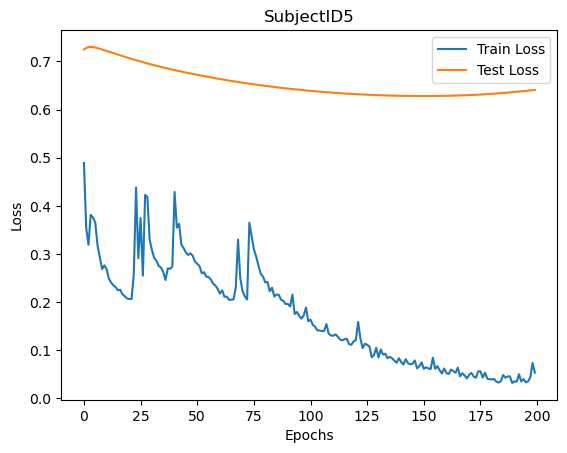

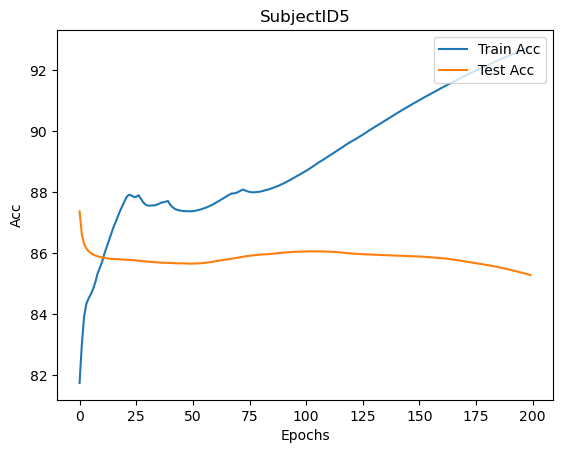


Subject 7
device: cuda
| epoch   0 | 0.2594 s/epoch | train loss 0.4717
| epoch   1 | 0.2637 s/epoch | train loss 0.3333
| epoch   2 | 0.2589 s/epoch | train loss 0.3179
| epoch   3 | 0.2613 s/epoch | train loss 0.2948
| epoch   4 | 0.2625 s/epoch | train loss 0.2797
| epoch   5 | 0.2639 s/epoch | train loss 0.2674
| epoch   6 | 0.2607 s/epoch | train loss 0.2650
| epoch   7 | 0.2628 s/epoch | train loss 0.2502
| epoch   8 | 0.2633 s/epoch | train loss 0.2415
| epoch   9 | 0.2639 s/epoch | train loss 0.2308
| epoch  10 | 0.2632 s/epoch | train loss 0.2385
| epoch  11 | 0.2640 s/epoch | train loss 0.2189
| epoch  12 | 0.2622 s/epoch | train loss 0.2194
| epoch  13 | 0.2628 s/epoch | train loss 0.2198
| epoch  14 | 0.2601 s/epoch | train loss 0.2139
| epoch  15 | 0.2616 s/epoch | train loss 0.2118
| epoch  16 | 0.2577 s/epoch | train loss 0.4396
| epoch  17 | 0.2568 s/epoch | train loss 0.7484
| epoch  18 | 0.2619 s/epoch | train loss 0.4252
| epoch  19 | 0.2622 s/epoch | train loss 0.4

| epoch 167 | 0.2630 s/epoch | train loss 0.1538
| epoch 168 | 0.2621 s/epoch | train loss 0.1425
| epoch 169 | 0.2597 s/epoch | train loss 0.1400
| epoch 170 | 0.2592 s/epoch | train loss 0.1492
| epoch 171 | 0.2623 s/epoch | train loss 0.1346
| epoch 172 | 0.2614 s/epoch | train loss 0.1268
| epoch 173 | 0.2582 s/epoch | train loss 0.1305
| epoch 174 | 0.2639 s/epoch | train loss 0.1277
| epoch 175 | 0.2627 s/epoch | train loss 0.1217
| epoch 176 | 0.2638 s/epoch | train loss 0.1185
| epoch 177 | 0.2647 s/epoch | train loss 0.1234
| epoch 178 | 0.2641 s/epoch | train loss 0.1134
| epoch 179 | 0.2628 s/epoch | train loss 0.1124
| epoch 180 | 0.2619 s/epoch | train loss 0.1133
| epoch 181 | 0.2631 s/epoch | train loss 0.0975
| epoch 182 | 0.2633 s/epoch | train loss 0.1005
| epoch 183 | 0.2620 s/epoch | train loss 0.1045
| epoch 184 | 0.2627 s/epoch | train loss 0.0948
| epoch 185 | 0.2639 s/epoch | train loss 0.0947
| epoch 186 | 0.2635 s/epoch | train loss 0.0917
| epoch 187 | 0.2635

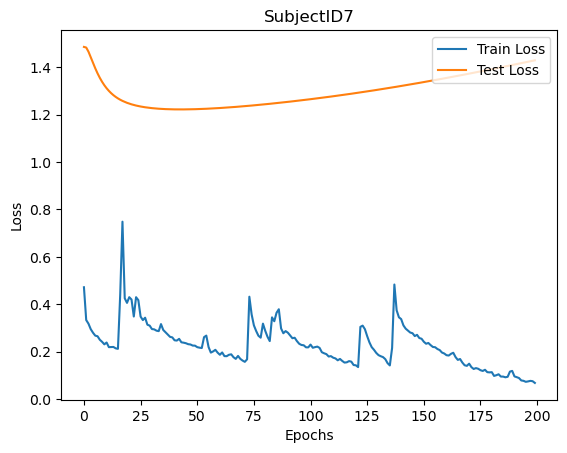

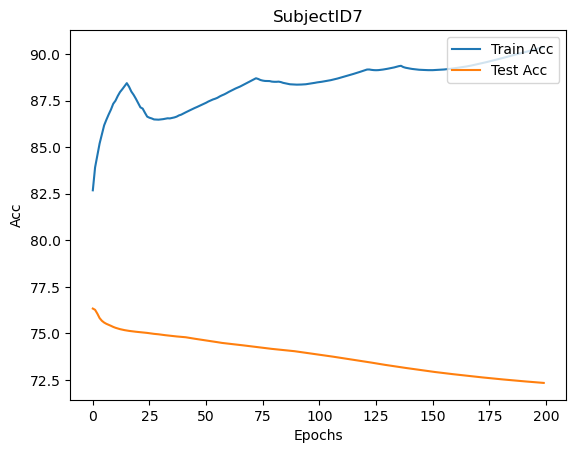

| epoch   0 | 0.2626 s/epoch | train loss 0.4185
| epoch   1 | 0.2613 s/epoch | train loss 0.3344
| epoch   2 | 0.2600 s/epoch | train loss 0.3022
| epoch   3 | 0.2609 s/epoch | train loss 0.2818
| epoch   4 | 0.2637 s/epoch | train loss 0.2712
| epoch   5 | 0.2622 s/epoch | train loss 0.2957
| epoch   6 | 0.2616 s/epoch | train loss 0.3817
| epoch   7 | 0.2637 s/epoch | train loss 0.3440
| epoch   8 | 0.2622 s/epoch | train loss 0.3124
| epoch   9 | 0.2620 s/epoch | train loss 0.3068
| epoch  10 | 0.2609 s/epoch | train loss 0.2869
| epoch  11 | 0.2646 s/epoch | train loss 0.2791
| epoch  12 | 0.2608 s/epoch | train loss 0.2758
| epoch  13 | 0.2602 s/epoch | train loss 0.2638
| epoch  14 | 0.2631 s/epoch | train loss 0.2544
| epoch  15 | 0.2610 s/epoch | train loss 0.2507
| epoch  16 | 0.2619 s/epoch | train loss 0.2365
| epoch  17 | 0.2583 s/epoch | train loss 0.2321
| epoch  18 | 0.2563 s/epoch | train loss 0.2549
| epoch  19 | 0.2595 s/epoch | train loss 0.3536
| epoch  20 | 0.2579

| epoch 168 | 0.3213 s/epoch | train loss 0.0240
| epoch 169 | 0.3217 s/epoch | train loss 0.0552
| epoch 170 | 0.3242 s/epoch | train loss 0.0294
| epoch 171 | 0.3164 s/epoch | train loss 0.0326
| epoch 172 | 0.3250 s/epoch | train loss 0.0272
| epoch 173 | 0.3206 s/epoch | train loss 0.0258
| epoch 174 | 0.3231 s/epoch | train loss 0.0256
| epoch 175 | 0.3171 s/epoch | train loss 0.0305
| epoch 176 | 0.3215 s/epoch | train loss 0.0365
| epoch 177 | 0.3175 s/epoch | train loss 0.0240
| epoch 178 | 0.3214 s/epoch | train loss 0.0257
| epoch 179 | 0.3210 s/epoch | train loss 0.0237
| epoch 180 | 0.3192 s/epoch | train loss 0.0291
| epoch 181 | 0.3212 s/epoch | train loss 0.0442
| epoch 182 | 0.3225 s/epoch | train loss 0.2062
| epoch 183 | 0.3193 s/epoch | train loss 0.1319
| epoch 184 | 0.3233 s/epoch | train loss 0.0745
| epoch 185 | 0.3206 s/epoch | train loss 0.0699
| epoch 186 | 0.3170 s/epoch | train loss 0.0467
| epoch 187 | 0.3207 s/epoch | train loss 0.0438
| epoch 188 | 0.3200

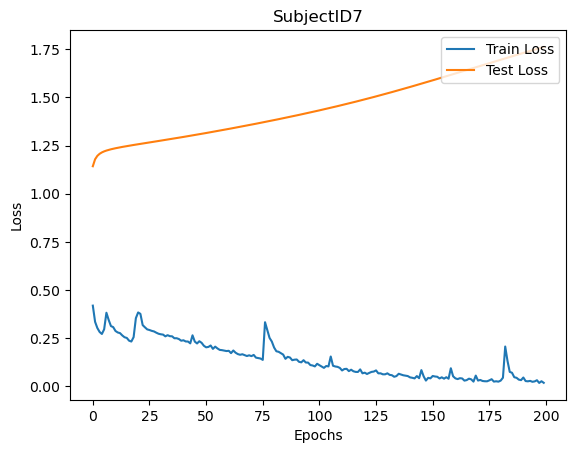

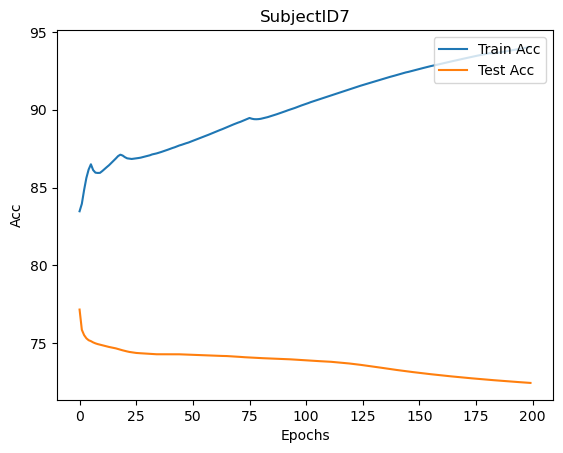


Subject 8
device: cuda
| epoch   0 | 0.3338 s/epoch | train loss 0.4669
| epoch   1 | 0.3276 s/epoch | train loss 0.3298
| epoch   2 | 0.3311 s/epoch | train loss 0.3249
| epoch   3 | 0.3284 s/epoch | train loss 0.3555
| epoch   4 | 0.3314 s/epoch | train loss 0.3337
| epoch   5 | 0.3240 s/epoch | train loss 0.3054
| epoch   6 | 0.3318 s/epoch | train loss 0.2865
| epoch   7 | 0.3292 s/epoch | train loss 0.3657
| epoch   8 | 0.3191 s/epoch | train loss 0.4943
| epoch   9 | 0.2758 s/epoch | train loss 0.4530
| epoch  10 | 0.2761 s/epoch | train loss 0.3338
| epoch  11 | 0.2767 s/epoch | train loss 0.3187
| epoch  12 | 0.2747 s/epoch | train loss 0.2952
| epoch  13 | 0.2753 s/epoch | train loss 0.2806
| epoch  14 | 0.2751 s/epoch | train loss 0.3239
| epoch  15 | 0.2760 s/epoch | train loss 0.3073
| epoch  16 | 0.2764 s/epoch | train loss 0.3449
| epoch  17 | 0.2753 s/epoch | train loss 0.3669
| epoch  18 | 0.2767 s/epoch | train loss 0.3363
| epoch  19 | 0.2734 s/epoch | train loss 0.3

| epoch 167 | 0.1519 s/epoch | train loss 0.0635
| epoch 168 | 0.1446 s/epoch | train loss 0.0564
| epoch 169 | 0.1438 s/epoch | train loss 0.0594
| epoch 170 | 0.1488 s/epoch | train loss 0.0453
| epoch 171 | 0.1523 s/epoch | train loss 0.0508
| epoch 172 | 0.1515 s/epoch | train loss 0.0504
| epoch 173 | 0.1453 s/epoch | train loss 0.0479
| epoch 174 | 0.1441 s/epoch | train loss 0.0468
| epoch 175 | 0.1461 s/epoch | train loss 0.0414
| epoch 176 | 0.1529 s/epoch | train loss 0.0552
| epoch 177 | 0.1521 s/epoch | train loss 0.0488
| epoch 178 | 0.1518 s/epoch | train loss 0.0426
| epoch 179 | 0.1532 s/epoch | train loss 0.0488
| epoch 180 | 0.1518 s/epoch | train loss 0.0378
| epoch 181 | 0.1511 s/epoch | train loss 0.0365
| epoch 182 | 0.1505 s/epoch | train loss 0.0463
| epoch 183 | 0.1517 s/epoch | train loss 0.0372
| epoch 184 | 0.1513 s/epoch | train loss 0.0387
| epoch 185 | 0.1517 s/epoch | train loss 0.0436
| epoch 186 | 0.1514 s/epoch | train loss 0.0455
| epoch 187 | 0.1511

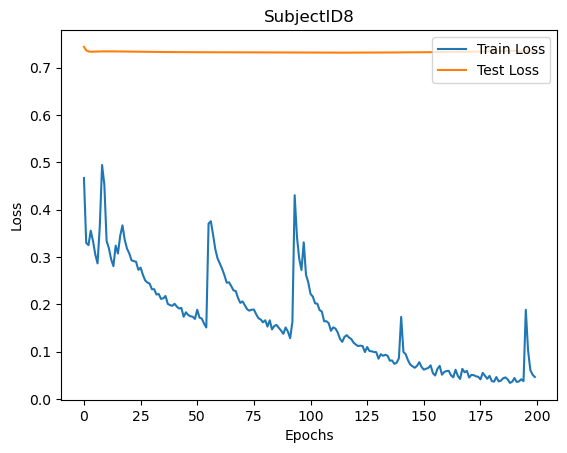

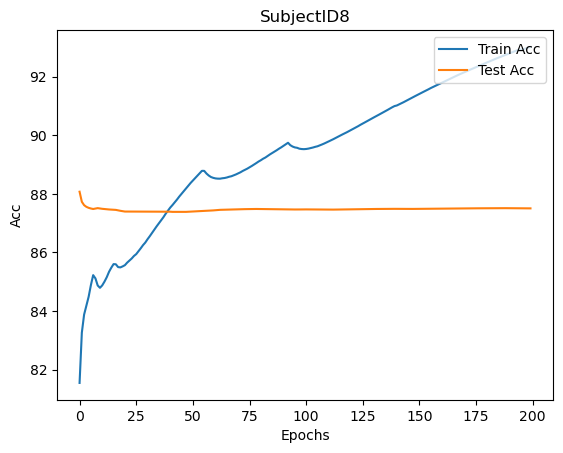

| epoch   0 | 0.1534 s/epoch | train loss 0.5634
| epoch   1 | 0.1523 s/epoch | train loss 0.3918
| epoch   2 | 0.1507 s/epoch | train loss 0.3508
| epoch   3 | 0.1512 s/epoch | train loss 0.3179
| epoch   4 | 0.1518 s/epoch | train loss 0.3018
| epoch   5 | 0.1523 s/epoch | train loss 0.3135
| epoch   6 | 0.1516 s/epoch | train loss 0.2769
| epoch   7 | 0.1512 s/epoch | train loss 0.2706
| epoch   8 | 0.1519 s/epoch | train loss 0.2614
| epoch   9 | 0.1520 s/epoch | train loss 0.2454
| epoch  10 | 0.1536 s/epoch | train loss 0.2414
| epoch  11 | 0.1513 s/epoch | train loss 0.2351
| epoch  12 | 0.1519 s/epoch | train loss 0.2359
| epoch  13 | 0.1503 s/epoch | train loss 0.2317
| epoch  14 | 0.1528 s/epoch | train loss 0.2246
| epoch  15 | 0.1505 s/epoch | train loss 0.2469
| epoch  16 | 0.1508 s/epoch | train loss 0.2612
| epoch  17 | 0.1524 s/epoch | train loss 0.2250
| epoch  18 | 0.1521 s/epoch | train loss 0.2180
| epoch  19 | 0.1518 s/epoch | train loss 0.2016
| epoch  20 | 0.1516

| epoch 168 | 0.1521 s/epoch | train loss 0.0878
| epoch 169 | 0.1526 s/epoch | train loss 0.0983
| epoch 170 | 0.1513 s/epoch | train loss 0.0936
| epoch 171 | 0.1518 s/epoch | train loss 0.0828
| epoch 172 | 0.1508 s/epoch | train loss 0.0797
| epoch 173 | 0.1444 s/epoch | train loss 0.0675
| epoch 174 | 0.1433 s/epoch | train loss 0.0882
| epoch 175 | 0.1415 s/epoch | train loss 0.0772
| epoch 176 | 0.1380 s/epoch | train loss 0.0731
| epoch 177 | 0.1383 s/epoch | train loss 0.0742
| epoch 178 | 0.1383 s/epoch | train loss 0.0678
| epoch 179 | 0.1384 s/epoch | train loss 0.0762
| epoch 180 | 0.1383 s/epoch | train loss 0.0914
| epoch 181 | 0.1384 s/epoch | train loss 0.0707
| epoch 182 | 0.1382 s/epoch | train loss 0.0620
| epoch 183 | 0.1381 s/epoch | train loss 0.0717
| epoch 184 | 0.1384 s/epoch | train loss 0.1454
| epoch 185 | 0.1383 s/epoch | train loss 0.1364
| epoch 186 | 0.1381 s/epoch | train loss 0.0848
| epoch 187 | 0.1383 s/epoch | train loss 0.0678
| epoch 188 | 0.1383

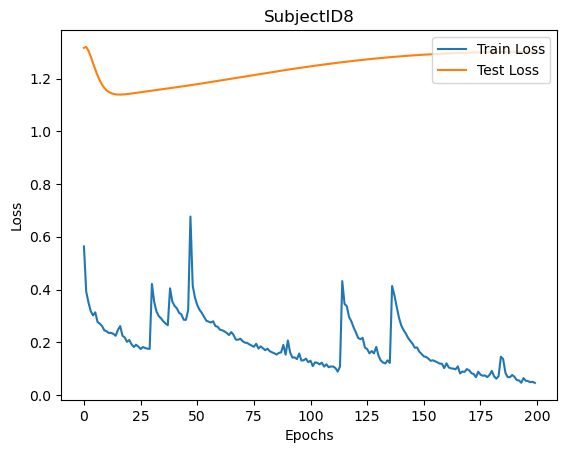

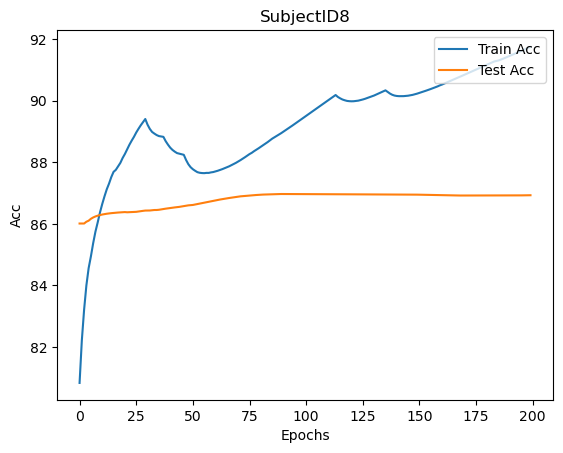


Subject 9
device: cuda
| epoch   0 | 0.1343 s/epoch | train loss 0.4913
| epoch   1 | 0.1356 s/epoch | train loss 0.4039
| epoch   2 | 0.1354 s/epoch | train loss 0.3256
| epoch   3 | 0.1354 s/epoch | train loss 0.2967
| epoch   4 | 0.1356 s/epoch | train loss 0.2921
| epoch   5 | 0.1355 s/epoch | train loss 0.3202
| epoch   6 | 0.1354 s/epoch | train loss 0.2842
| epoch   7 | 0.1352 s/epoch | train loss 0.2686
| epoch   8 | 0.1365 s/epoch | train loss 0.2600
| epoch   9 | 0.1354 s/epoch | train loss 0.2681
| epoch  10 | 0.1354 s/epoch | train loss 0.2443
| epoch  11 | 0.1354 s/epoch | train loss 0.2444
| epoch  12 | 0.1356 s/epoch | train loss 0.2305
| epoch  13 | 0.1356 s/epoch | train loss 0.2198
| epoch  14 | 0.1353 s/epoch | train loss 0.2275
| epoch  15 | 0.1354 s/epoch | train loss 0.2151
| epoch  16 | 0.1352 s/epoch | train loss 0.2099
| epoch  17 | 0.1352 s/epoch | train loss 0.2022
| epoch  18 | 0.1355 s/epoch | train loss 0.1973
| epoch  19 | 0.1359 s/epoch | train loss 0.2

| epoch 167 | 0.1361 s/epoch | train loss 0.0857
| epoch 168 | 0.1356 s/epoch | train loss 0.0677
| epoch 169 | 0.1358 s/epoch | train loss 0.0800
| epoch 170 | 0.1358 s/epoch | train loss 0.0676
| epoch 171 | 0.1359 s/epoch | train loss 0.0631
| epoch 172 | 0.1355 s/epoch | train loss 0.0720
| epoch 173 | 0.1355 s/epoch | train loss 0.0672
| epoch 174 | 0.1357 s/epoch | train loss 0.0698
| epoch 175 | 0.1357 s/epoch | train loss 0.0738
| epoch 176 | 0.1358 s/epoch | train loss 0.0637
| epoch 177 | 0.1358 s/epoch | train loss 0.0617
| epoch 178 | 0.1359 s/epoch | train loss 0.0624
| epoch 179 | 0.1357 s/epoch | train loss 0.0717
| epoch 180 | 0.1355 s/epoch | train loss 0.0486
| epoch 181 | 0.1357 s/epoch | train loss 0.0700
| epoch 182 | 0.1358 s/epoch | train loss 0.0522
| epoch 183 | 0.1357 s/epoch | train loss 0.0513
| epoch 184 | 0.1357 s/epoch | train loss 0.0610
| epoch 185 | 0.1360 s/epoch | train loss 0.0525
| epoch 186 | 0.1354 s/epoch | train loss 0.0575
| epoch 187 | 0.1356

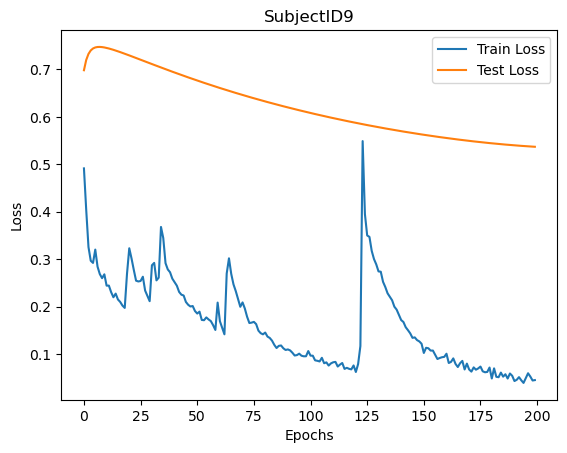

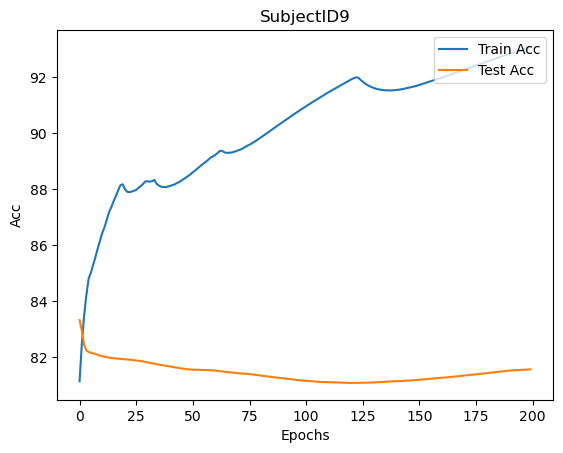

| epoch   0 | 0.1343 s/epoch | train loss 0.4584
| epoch   1 | 0.1355 s/epoch | train loss 0.3599
| epoch   2 | 0.1354 s/epoch | train loss 0.3253
| epoch   3 | 0.1357 s/epoch | train loss 0.3004
| epoch   4 | 0.1354 s/epoch | train loss 0.2916
| epoch   5 | 0.1353 s/epoch | train loss 0.2878
| epoch   6 | 0.1352 s/epoch | train loss 0.2675
| epoch   7 | 0.1359 s/epoch | train loss 0.2505
| epoch   8 | 0.1357 s/epoch | train loss 0.2473
| epoch   9 | 0.1354 s/epoch | train loss 0.2306
| epoch  10 | 0.1354 s/epoch | train loss 0.2275
| epoch  11 | 0.1355 s/epoch | train loss 0.2259
| epoch  12 | 0.1354 s/epoch | train loss 0.2229
| epoch  13 | 0.1353 s/epoch | train loss 0.2138
| epoch  14 | 0.1358 s/epoch | train loss 0.2172
| epoch  15 | 0.1356 s/epoch | train loss 0.2173
| epoch  16 | 0.1354 s/epoch | train loss 0.1967
| epoch  17 | 0.1355 s/epoch | train loss 0.1963
| epoch  18 | 0.1365 s/epoch | train loss 0.1951
| epoch  19 | 0.1356 s/epoch | train loss 0.2057
| epoch  20 | 0.1354

| epoch 168 | 0.1348 s/epoch | train loss 0.1412
| epoch 169 | 0.1350 s/epoch | train loss 0.0803
| epoch 170 | 0.1346 s/epoch | train loss 0.0696
| epoch 171 | 0.1346 s/epoch | train loss 0.0555
| epoch 172 | 0.1348 s/epoch | train loss 0.0498
| epoch 173 | 0.1351 s/epoch | train loss 0.0515
| epoch 174 | 0.1347 s/epoch | train loss 0.0336
| epoch 175 | 0.1346 s/epoch | train loss 0.0383
| epoch 176 | 0.1344 s/epoch | train loss 0.0362
| epoch 177 | 0.1347 s/epoch | train loss 0.0374
| epoch 178 | 0.1345 s/epoch | train loss 0.0446
| epoch 179 | 0.1348 s/epoch | train loss 0.0388
| epoch 180 | 0.1349 s/epoch | train loss 0.0357
| epoch 181 | 0.1348 s/epoch | train loss 0.0440
| epoch 182 | 0.1348 s/epoch | train loss 0.0464
| epoch 183 | 0.1345 s/epoch | train loss 0.0328
| epoch 184 | 0.1347 s/epoch | train loss 0.0344
| epoch 185 | 0.1346 s/epoch | train loss 0.0377
| epoch 186 | 0.1345 s/epoch | train loss 0.0379
| epoch 187 | 0.1346 s/epoch | train loss 0.0375
| epoch 188 | 0.1348

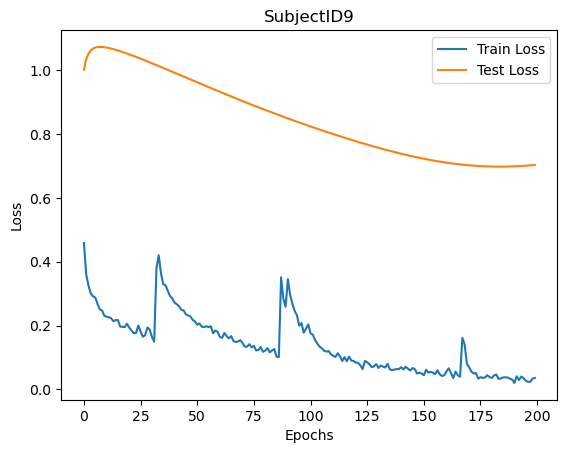

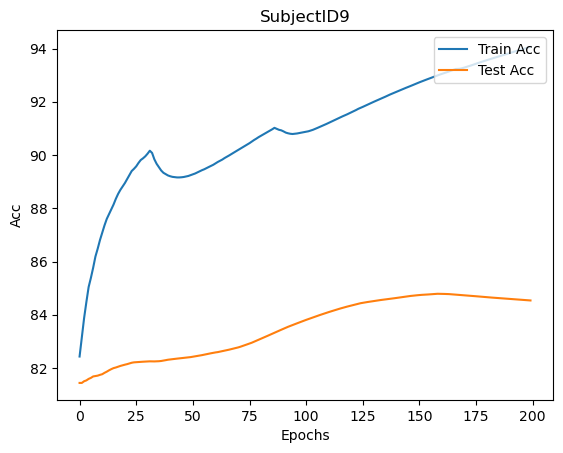


Subject 10
device: cuda
| epoch   0 | 0.1381 s/epoch | train loss 0.4343
| epoch   1 | 0.1394 s/epoch | train loss 0.3429
| epoch   2 | 0.1398 s/epoch | train loss 0.3182
| epoch   3 | 0.1398 s/epoch | train loss 0.2998
| epoch   4 | 0.1398 s/epoch | train loss 0.2961
| epoch   5 | 0.1394 s/epoch | train loss 0.2810
| epoch   6 | 0.1395 s/epoch | train loss 0.2820
| epoch   7 | 0.1396 s/epoch | train loss 0.2694
| epoch   8 | 0.1394 s/epoch | train loss 0.2538
| epoch   9 | 0.1394 s/epoch | train loss 0.2585
| epoch  10 | 0.1395 s/epoch | train loss 0.2410
| epoch  11 | 0.1393 s/epoch | train loss 0.2699
| epoch  12 | 0.1400 s/epoch | train loss 0.2847
| epoch  13 | 0.1397 s/epoch | train loss 0.2471
| epoch  14 | 0.1396 s/epoch | train loss 0.2235
| epoch  15 | 0.1397 s/epoch | train loss 0.2277
| epoch  16 | 0.1397 s/epoch | train loss 0.2253
| epoch  17 | 0.1399 s/epoch | train loss 0.2151
| epoch  18 | 0.1397 s/epoch | train loss 0.2094
| epoch  19 | 0.1398 s/epoch | train loss 0.

| epoch 167 | 0.1399 s/epoch | train loss 0.0505
| epoch 168 | 0.1397 s/epoch | train loss 0.0574
| epoch 169 | 0.1397 s/epoch | train loss 0.0440
| epoch 170 | 0.1399 s/epoch | train loss 0.0428
| epoch 171 | 0.1399 s/epoch | train loss 0.0427
| epoch 172 | 0.1400 s/epoch | train loss 0.0436
| epoch 173 | 0.1396 s/epoch | train loss 0.0408
| epoch 174 | 0.1400 s/epoch | train loss 0.0556
| epoch 175 | 0.1396 s/epoch | train loss 0.0510
| epoch 176 | 0.1398 s/epoch | train loss 0.0492
| epoch 177 | 0.1398 s/epoch | train loss 0.0425
| epoch 178 | 0.1397 s/epoch | train loss 0.0464
| epoch 179 | 0.1397 s/epoch | train loss 0.0420
| epoch 180 | 0.1399 s/epoch | train loss 0.0377
| epoch 181 | 0.1401 s/epoch | train loss 0.0471
| epoch 182 | 0.1398 s/epoch | train loss 0.0495
| epoch 183 | 0.1399 s/epoch | train loss 0.0440
| epoch 184 | 0.1398 s/epoch | train loss 0.0312
| epoch 185 | 0.1400 s/epoch | train loss 0.0371
| epoch 186 | 0.1402 s/epoch | train loss 0.0407
| epoch 187 | 0.1400

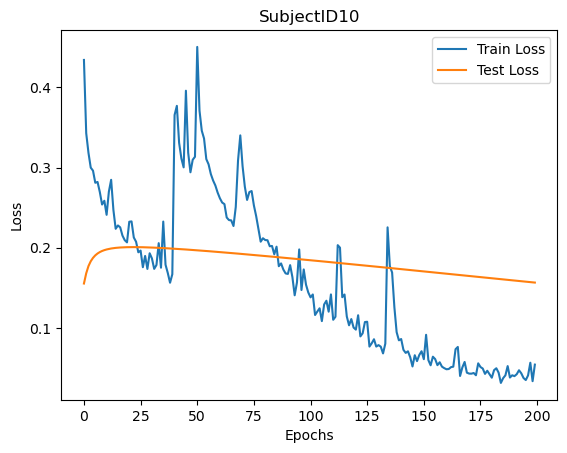

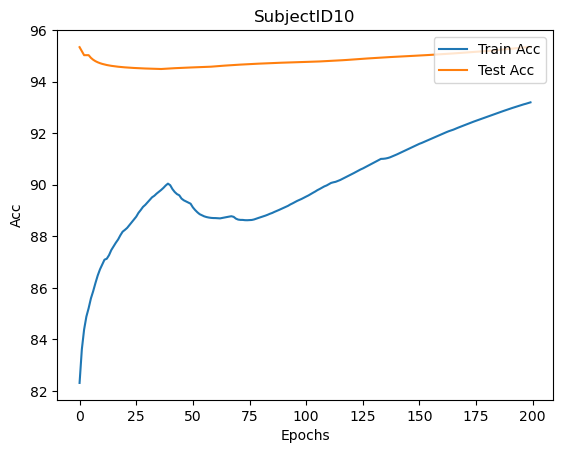

| epoch   0 | 0.1382 s/epoch | train loss 0.4954
| epoch   1 | 0.1382 s/epoch | train loss 0.3554
| epoch   2 | 0.1389 s/epoch | train loss 0.3190
| epoch   3 | 0.1386 s/epoch | train loss 0.3168
| epoch   4 | 0.1383 s/epoch | train loss 0.3126
| epoch   5 | 0.1384 s/epoch | train loss 0.3097
| epoch   6 | 0.1384 s/epoch | train loss 0.2798
| epoch   7 | 0.1381 s/epoch | train loss 0.2824
| epoch   8 | 0.1384 s/epoch | train loss 0.3114
| epoch   9 | 0.1386 s/epoch | train loss 0.3490
| epoch  10 | 0.1386 s/epoch | train loss 0.3020
| epoch  11 | 0.1385 s/epoch | train loss 0.3313
| epoch  12 | 0.1384 s/epoch | train loss 0.5165
| epoch  13 | 0.1387 s/epoch | train loss 0.3882
| epoch  14 | 0.1386 s/epoch | train loss 0.3570
| epoch  15 | 0.1386 s/epoch | train loss 0.3347
| epoch  16 | 0.1385 s/epoch | train loss 0.3281
| epoch  17 | 0.1387 s/epoch | train loss 0.3110
| epoch  18 | 0.1387 s/epoch | train loss 0.3005
| epoch  19 | 0.1385 s/epoch | train loss 0.2870
| epoch  20 | 0.1385

| epoch 168 | 0.1390 s/epoch | train loss 0.0354
| epoch 169 | 0.1388 s/epoch | train loss 0.0365
| epoch 170 | 0.1387 s/epoch | train loss 0.0857
| epoch 171 | 0.1388 s/epoch | train loss 0.0376
| epoch 172 | 0.1389 s/epoch | train loss 0.0372
| epoch 173 | 0.1389 s/epoch | train loss 0.0298
| epoch 174 | 0.1390 s/epoch | train loss 0.0296
| epoch 175 | 0.1389 s/epoch | train loss 0.0422
| epoch 176 | 0.1390 s/epoch | train loss 0.0445
| epoch 177 | 0.1388 s/epoch | train loss 0.0248
| epoch 178 | 0.1389 s/epoch | train loss 0.0272
| epoch 179 | 0.1391 s/epoch | train loss 0.0405
| epoch 180 | 0.1388 s/epoch | train loss 0.0335
| epoch 181 | 0.1388 s/epoch | train loss 0.0314
| epoch 182 | 0.1389 s/epoch | train loss 0.0329
| epoch 183 | 0.1390 s/epoch | train loss 0.0295
| epoch 184 | 0.1386 s/epoch | train loss 0.1626
| epoch 185 | 0.1387 s/epoch | train loss 0.1111
| epoch 186 | 0.1387 s/epoch | train loss 0.0623
| epoch 187 | 0.1388 s/epoch | train loss 0.0459
| epoch 188 | 0.1386

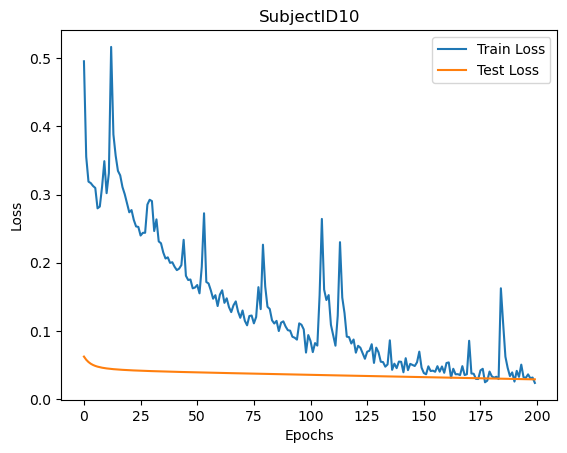

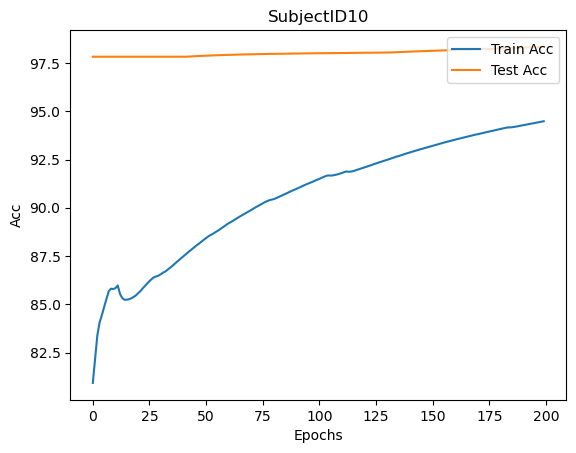


Subject 11
device: cuda
| epoch   0 | 0.1395 s/epoch | train loss 0.4805
| epoch   1 | 0.1374 s/epoch | train loss 0.3513
| epoch   2 | 0.1372 s/epoch | train loss 0.3287
| epoch   3 | 0.1371 s/epoch | train loss 0.3233
| epoch   4 | 0.1372 s/epoch | train loss 0.3177
| epoch   5 | 0.1370 s/epoch | train loss 0.3204
| epoch   6 | 0.1373 s/epoch | train loss 0.2806
| epoch   7 | 0.1371 s/epoch | train loss 0.2777
| epoch   8 | 0.1369 s/epoch | train loss 0.2709
| epoch   9 | 0.1368 s/epoch | train loss 0.3076
| epoch  10 | 0.1372 s/epoch | train loss 0.2738
| epoch  11 | 0.1372 s/epoch | train loss 0.2738
| epoch  12 | 0.1373 s/epoch | train loss 0.2518
| epoch  13 | 0.1372 s/epoch | train loss 0.2582
| epoch  14 | 0.1371 s/epoch | train loss 0.2402
| epoch  15 | 0.1371 s/epoch | train loss 0.2296
| epoch  16 | 0.1373 s/epoch | train loss 0.2369
| epoch  17 | 0.1371 s/epoch | train loss 0.3641
| epoch  18 | 0.1370 s/epoch | train loss 0.3582
| epoch  19 | 0.1373 s/epoch | train loss 0.

| epoch 167 | 0.1374 s/epoch | train loss 0.0596
| epoch 168 | 0.1376 s/epoch | train loss 0.0547
| epoch 169 | 0.1374 s/epoch | train loss 0.0482
| epoch 170 | 0.1374 s/epoch | train loss 0.0439
| epoch 171 | 0.1374 s/epoch | train loss 0.0459
| epoch 172 | 0.1376 s/epoch | train loss 0.0420
| epoch 173 | 0.1374 s/epoch | train loss 0.0504
| epoch 174 | 0.1373 s/epoch | train loss 0.0466
| epoch 175 | 0.1376 s/epoch | train loss 0.0464
| epoch 176 | 0.1374 s/epoch | train loss 0.0522
| epoch 177 | 0.1374 s/epoch | train loss 0.0403
| epoch 178 | 0.1374 s/epoch | train loss 0.0356
| epoch 179 | 0.1375 s/epoch | train loss 0.0400
| epoch 180 | 0.1374 s/epoch | train loss 0.0502
| epoch 181 | 0.1374 s/epoch | train loss 0.0474
| epoch 182 | 0.1375 s/epoch | train loss 0.0431
| epoch 183 | 0.1375 s/epoch | train loss 0.0427
| epoch 184 | 0.1374 s/epoch | train loss 0.0716
| epoch 185 | 0.1374 s/epoch | train loss 0.0500
| epoch 186 | 0.1374 s/epoch | train loss 0.0389
| epoch 187 | 0.1372

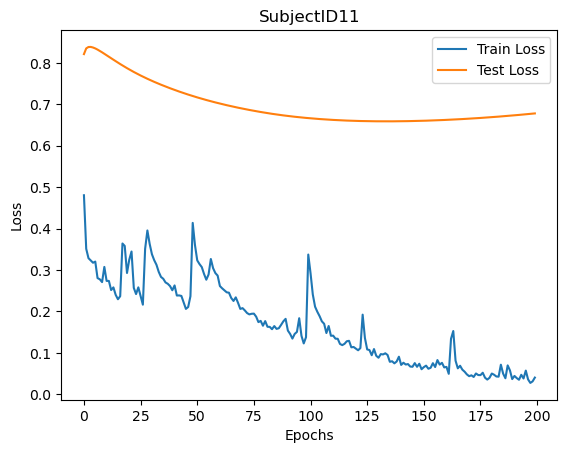

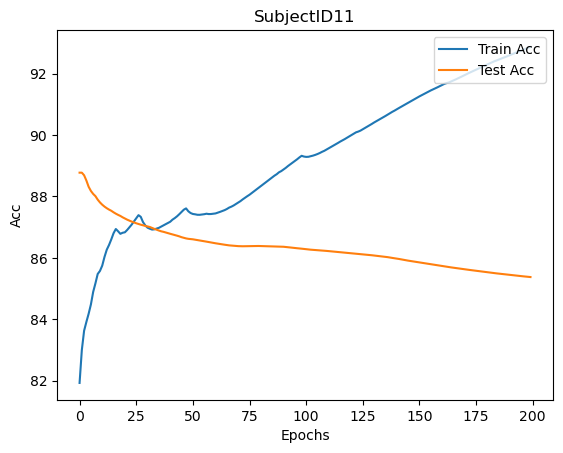

| epoch   0 | 0.1375 s/epoch | train loss 0.4554
| epoch   1 | 0.1374 s/epoch | train loss 0.3869
| epoch   2 | 0.1374 s/epoch | train loss 0.3500
| epoch   3 | 0.1371 s/epoch | train loss 0.3271
| epoch   4 | 0.1372 s/epoch | train loss 0.3018
| epoch   5 | 0.1371 s/epoch | train loss 0.2934
| epoch   6 | 0.1372 s/epoch | train loss 0.2866
| epoch   7 | 0.1371 s/epoch | train loss 0.2815
| epoch   8 | 0.1373 s/epoch | train loss 0.2870
| epoch   9 | 0.1372 s/epoch | train loss 0.2679
| epoch  10 | 0.1372 s/epoch | train loss 0.3079
| epoch  11 | 0.1373 s/epoch | train loss 0.2461
| epoch  12 | 0.1374 s/epoch | train loss 0.3726
| epoch  13 | 0.1377 s/epoch | train loss 0.3512
| epoch  14 | 0.1372 s/epoch | train loss 0.3062
| epoch  15 | 0.1376 s/epoch | train loss 0.2805
| epoch  16 | 0.1377 s/epoch | train loss 0.2584
| epoch  17 | 0.1372 s/epoch | train loss 0.2576
| epoch  18 | 0.1374 s/epoch | train loss 0.2757
| epoch  19 | 0.1376 s/epoch | train loss 0.3324
| epoch  20 | 0.1372

| epoch 168 | 0.1375 s/epoch | train loss 0.0468
| epoch 169 | 0.1374 s/epoch | train loss 0.0450
| epoch 170 | 0.1374 s/epoch | train loss 0.0539
| epoch 171 | 0.1376 s/epoch | train loss 0.0356
| epoch 172 | 0.1376 s/epoch | train loss 0.0396
| epoch 173 | 0.1376 s/epoch | train loss 0.0415
| epoch 174 | 0.1374 s/epoch | train loss 0.0565
| epoch 175 | 0.1378 s/epoch | train loss 0.0418
| epoch 176 | 0.1376 s/epoch | train loss 0.0394
| epoch 177 | 0.1376 s/epoch | train loss 0.0571
| epoch 178 | 0.1375 s/epoch | train loss 0.0435
| epoch 179 | 0.1378 s/epoch | train loss 0.0437
| epoch 180 | 0.1376 s/epoch | train loss 0.0407
| epoch 181 | 0.1375 s/epoch | train loss 0.0436
| epoch 182 | 0.1378 s/epoch | train loss 0.0527
| epoch 183 | 0.1376 s/epoch | train loss 0.0482
| epoch 184 | 0.1376 s/epoch | train loss 0.0356
| epoch 185 | 0.1378 s/epoch | train loss 0.0343
| epoch 186 | 0.1377 s/epoch | train loss 0.0404
| epoch 187 | 0.1375 s/epoch | train loss 0.0315
| epoch 188 | 0.1375

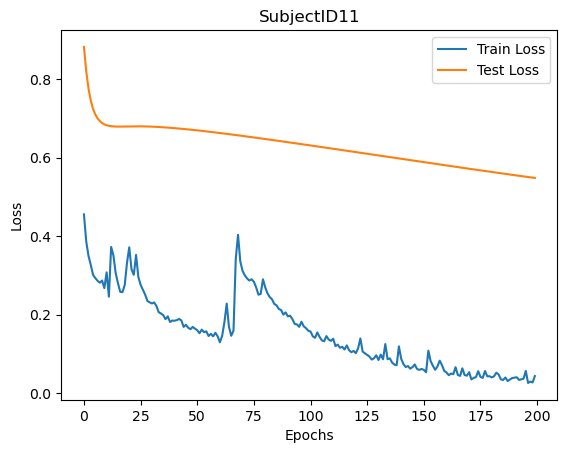

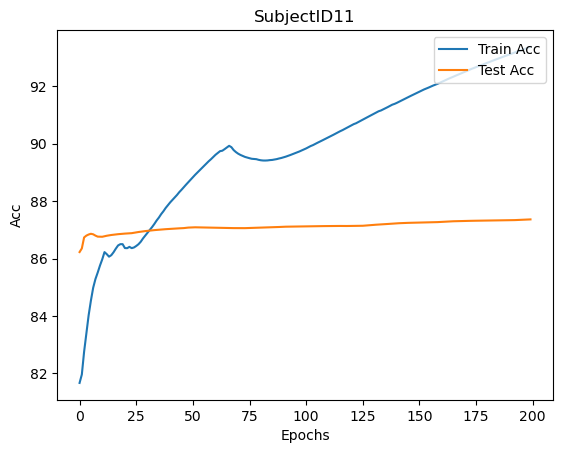


Subject 12
device: cuda
| epoch   0 | 0.1315 s/epoch | train loss 0.4379
| epoch   1 | 0.1311 s/epoch | train loss 0.3427
| epoch   2 | 0.1314 s/epoch | train loss 0.3270
| epoch   3 | 0.1311 s/epoch | train loss 0.3033
| epoch   4 | 0.1311 s/epoch | train loss 0.3629
| epoch   5 | 0.1311 s/epoch | train loss 0.3455
| epoch   6 | 0.1309 s/epoch | train loss 0.2959
| epoch   7 | 0.1310 s/epoch | train loss 0.3156
| epoch   8 | 0.1310 s/epoch | train loss 0.3696
| epoch   9 | 0.1307 s/epoch | train loss 0.3608
| epoch  10 | 0.1310 s/epoch | train loss 0.4739
| epoch  11 | 0.1308 s/epoch | train loss 0.6136
| epoch  12 | 0.1308 s/epoch | train loss 0.3702
| epoch  13 | 0.1308 s/epoch | train loss 0.3547
| epoch  14 | 0.1309 s/epoch | train loss 0.3379
| epoch  15 | 0.1308 s/epoch | train loss 0.3389
| epoch  16 | 0.1308 s/epoch | train loss 0.3242
| epoch  17 | 0.1307 s/epoch | train loss 0.3098
| epoch  18 | 0.1308 s/epoch | train loss 0.2943
| epoch  19 | 0.1308 s/epoch | train loss 0.

| epoch 167 | 0.1309 s/epoch | train loss 0.0599
| epoch 168 | 0.1309 s/epoch | train loss 0.0606
| epoch 169 | 0.1307 s/epoch | train loss 0.0528
| epoch 170 | 0.1309 s/epoch | train loss 0.0631
| epoch 171 | 0.1309 s/epoch | train loss 0.0474
| epoch 172 | 0.1309 s/epoch | train loss 0.0443
| epoch 173 | 0.1310 s/epoch | train loss 0.0569
| epoch 174 | 0.1308 s/epoch | train loss 0.0516
| epoch 175 | 0.1310 s/epoch | train loss 0.0665
| epoch 176 | 0.1309 s/epoch | train loss 0.0759
| epoch 177 | 0.1309 s/epoch | train loss 0.0474
| epoch 178 | 0.1311 s/epoch | train loss 0.0573
| epoch 179 | 0.1310 s/epoch | train loss 0.0464
| epoch 180 | 0.1311 s/epoch | train loss 0.0404
| epoch 181 | 0.1309 s/epoch | train loss 0.0544
| epoch 182 | 0.1310 s/epoch | train loss 0.0464
| epoch 183 | 0.1310 s/epoch | train loss 0.0445
| epoch 184 | 0.1310 s/epoch | train loss 0.0354
| epoch 185 | 0.1311 s/epoch | train loss 0.1286
| epoch 186 | 0.1310 s/epoch | train loss 0.0527
| epoch 187 | 0.1310

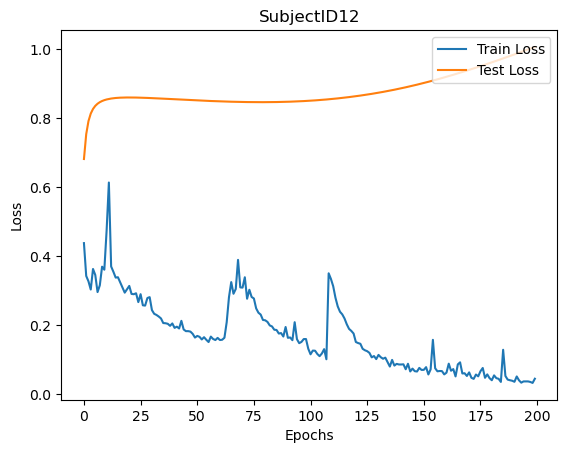

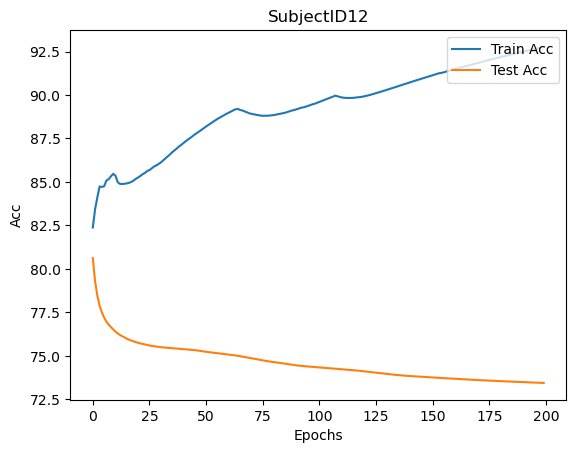

| epoch   0 | 0.1307 s/epoch | train loss 0.4751
| epoch   1 | 0.1306 s/epoch | train loss 0.3332
| epoch   2 | 0.1307 s/epoch | train loss 0.3452
| epoch   3 | 0.1307 s/epoch | train loss 0.3171
| epoch   4 | 0.1306 s/epoch | train loss 0.3153
| epoch   5 | 0.1305 s/epoch | train loss 0.4943
| epoch   6 | 0.1306 s/epoch | train loss 0.3842
| epoch   7 | 0.1307 s/epoch | train loss 0.3536
| epoch   8 | 0.1308 s/epoch | train loss 0.3866
| epoch   9 | 0.1309 s/epoch | train loss 0.3408
| epoch  10 | 0.1310 s/epoch | train loss 0.3393
| epoch  11 | 0.1308 s/epoch | train loss 0.3007
| epoch  12 | 0.1308 s/epoch | train loss 0.2765
| epoch  13 | 0.1306 s/epoch | train loss 0.2682
| epoch  14 | 0.1307 s/epoch | train loss 0.2620
| epoch  15 | 0.1307 s/epoch | train loss 0.2486
| epoch  16 | 0.1309 s/epoch | train loss 0.2377
| epoch  17 | 0.1307 s/epoch | train loss 0.2363
| epoch  18 | 0.1307 s/epoch | train loss 0.2268
| epoch  19 | 0.1309 s/epoch | train loss 0.2582
| epoch  20 | 0.1307

| epoch 168 | 0.1309 s/epoch | train loss 0.1237
| epoch 169 | 0.1311 s/epoch | train loss 0.3323
| epoch 170 | 0.1308 s/epoch | train loss 0.2546
| epoch 171 | 0.1310 s/epoch | train loss 0.2014
| epoch 172 | 0.1308 s/epoch | train loss 0.1690
| epoch 173 | 0.1309 s/epoch | train loss 0.1513
| epoch 174 | 0.1308 s/epoch | train loss 0.1484
| epoch 175 | 0.1306 s/epoch | train loss 0.1148
| epoch 176 | 0.1307 s/epoch | train loss 0.1120
| epoch 177 | 0.1307 s/epoch | train loss 0.0917
| epoch 178 | 0.1308 s/epoch | train loss 0.0816
| epoch 179 | 0.1308 s/epoch | train loss 0.0761
| epoch 180 | 0.1309 s/epoch | train loss 0.0799
| epoch 181 | 0.1309 s/epoch | train loss 0.0762
| epoch 182 | 0.1309 s/epoch | train loss 0.0682
| epoch 183 | 0.1309 s/epoch | train loss 0.0727
| epoch 184 | 0.1310 s/epoch | train loss 0.0624
| epoch 185 | 0.1309 s/epoch | train loss 0.0691
| epoch 186 | 0.1308 s/epoch | train loss 0.0634
| epoch 187 | 0.1307 s/epoch | train loss 0.1061
| epoch 188 | 0.1306

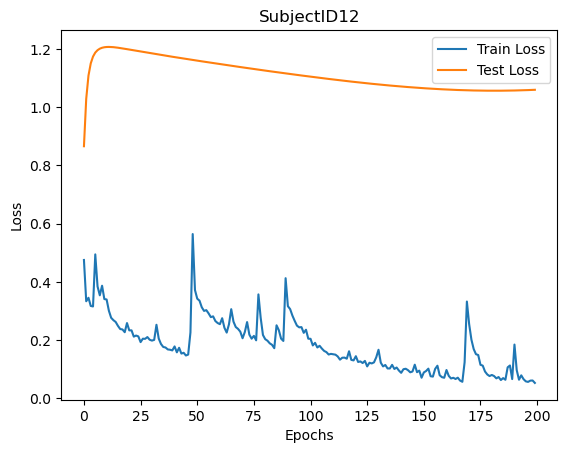

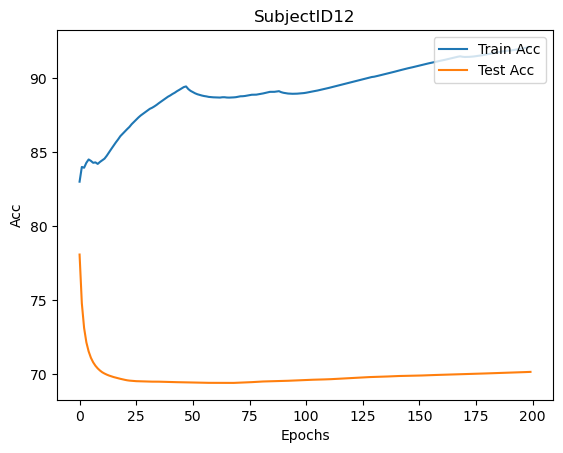


Subject 13
device: cuda
| epoch   0 | 0.1313 s/epoch | train loss 0.4894
| epoch   1 | 0.1312 s/epoch | train loss 0.3498
| epoch   2 | 0.1309 s/epoch | train loss 0.3190
| epoch   3 | 0.1310 s/epoch | train loss 0.3443
| epoch   4 | 0.1308 s/epoch | train loss 0.3113
| epoch   5 | 0.1308 s/epoch | train loss 0.3143
| epoch   6 | 0.1312 s/epoch | train loss 0.2902
| epoch   7 | 0.1311 s/epoch | train loss 0.3544
| epoch   8 | 0.1311 s/epoch | train loss 0.3055
| epoch   9 | 0.1311 s/epoch | train loss 0.2760
| epoch  10 | 0.1310 s/epoch | train loss 0.2574
| epoch  11 | 0.1307 s/epoch | train loss 0.2459
| epoch  12 | 0.1305 s/epoch | train loss 0.2380
| epoch  13 | 0.1305 s/epoch | train loss 0.2433
| epoch  14 | 0.1306 s/epoch | train loss 0.2290
| epoch  15 | 0.1306 s/epoch | train loss 0.3198
| epoch  16 | 0.1304 s/epoch | train loss 0.3039
| epoch  17 | 0.1305 s/epoch | train loss 0.2912
| epoch  18 | 0.1305 s/epoch | train loss 0.2689
| epoch  19 | 0.1306 s/epoch | train loss 0.

| epoch 167 | 0.1311 s/epoch | train loss 0.0594
| epoch 168 | 0.1309 s/epoch | train loss 0.0865
| epoch 169 | 0.1311 s/epoch | train loss 0.1459
| epoch 170 | 0.1310 s/epoch | train loss 0.3462
| epoch 171 | 0.1310 s/epoch | train loss 0.2340
| epoch 172 | 0.1309 s/epoch | train loss 0.1614
| epoch 173 | 0.1309 s/epoch | train loss 0.1088
| epoch 174 | 0.1309 s/epoch | train loss 0.0810
| epoch 175 | 0.1310 s/epoch | train loss 0.0768
| epoch 176 | 0.1310 s/epoch | train loss 0.0653
| epoch 177 | 0.1309 s/epoch | train loss 0.0668
| epoch 178 | 0.1310 s/epoch | train loss 0.0510
| epoch 179 | 0.1311 s/epoch | train loss 0.0453
| epoch 180 | 0.1309 s/epoch | train loss 0.0518
| epoch 181 | 0.1307 s/epoch | train loss 0.0341
| epoch 182 | 0.1309 s/epoch | train loss 0.0431
| epoch 183 | 0.1309 s/epoch | train loss 0.0482
| epoch 184 | 0.1307 s/epoch | train loss 0.0556
| epoch 185 | 0.1310 s/epoch | train loss 0.0413
| epoch 186 | 0.1309 s/epoch | train loss 0.0468
| epoch 187 | 0.1308

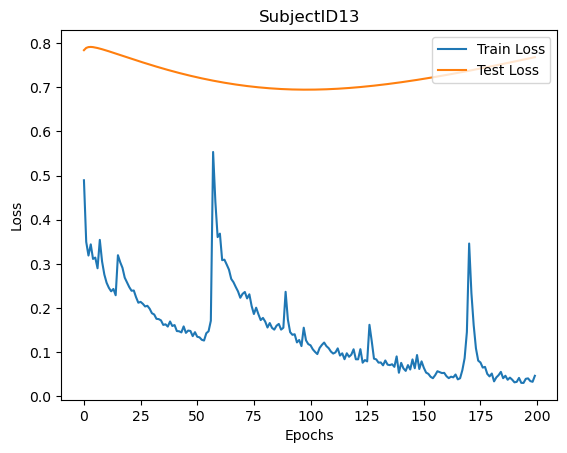

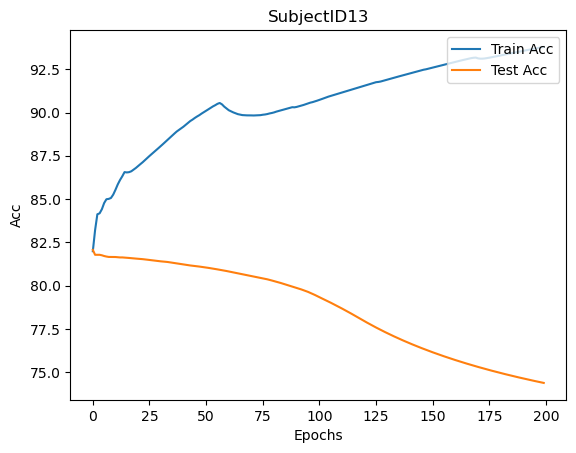

| epoch   0 | 0.1310 s/epoch | train loss 0.4132
| epoch   1 | 0.1311 s/epoch | train loss 0.3237
| epoch   2 | 0.1309 s/epoch | train loss 0.3216
| epoch   3 | 0.1308 s/epoch | train loss 0.2818
| epoch   4 | 0.1308 s/epoch | train loss 0.2700
| epoch   5 | 0.1309 s/epoch | train loss 0.2660
| epoch   6 | 0.1309 s/epoch | train loss 0.3920
| epoch   7 | 0.1309 s/epoch | train loss 0.3772
| epoch   8 | 0.1309 s/epoch | train loss 0.3297
| epoch   9 | 0.1310 s/epoch | train loss 0.3104
| epoch  10 | 0.1307 s/epoch | train loss 0.3019
| epoch  11 | 0.1307 s/epoch | train loss 0.2879
| epoch  12 | 0.1310 s/epoch | train loss 0.2811
| epoch  13 | 0.1312 s/epoch | train loss 0.2846
| epoch  14 | 0.1310 s/epoch | train loss 0.2598
| epoch  15 | 0.1310 s/epoch | train loss 0.2615
| epoch  16 | 0.1311 s/epoch | train loss 0.3786
| epoch  17 | 0.1309 s/epoch | train loss 0.4042
| epoch  18 | 0.1309 s/epoch | train loss 0.3658
| epoch  19 | 0.1308 s/epoch | train loss 0.3477
| epoch  20 | 0.1308

| epoch 168 | 0.1310 s/epoch | train loss 0.0696
| epoch 169 | 0.1311 s/epoch | train loss 0.0648
| epoch 170 | 0.1311 s/epoch | train loss 0.0878
| epoch 171 | 0.1311 s/epoch | train loss 0.0595
| epoch 172 | 0.1309 s/epoch | train loss 0.0560
| epoch 173 | 0.1311 s/epoch | train loss 0.0538
| epoch 174 | 0.1310 s/epoch | train loss 0.0618
| epoch 175 | 0.1310 s/epoch | train loss 0.0549
| epoch 176 | 0.1310 s/epoch | train loss 0.0544
| epoch 177 | 0.1311 s/epoch | train loss 0.0534
| epoch 178 | 0.1311 s/epoch | train loss 0.0652
| epoch 179 | 0.1309 s/epoch | train loss 0.0593
| epoch 180 | 0.1310 s/epoch | train loss 0.0565
| epoch 181 | 0.1310 s/epoch | train loss 0.0461
| epoch 182 | 0.1307 s/epoch | train loss 0.0561
| epoch 183 | 0.1309 s/epoch | train loss 0.0407
| epoch 184 | 0.1310 s/epoch | train loss 0.0728
| epoch 185 | 0.1312 s/epoch | train loss 0.0605
| epoch 186 | 0.1310 s/epoch | train loss 0.0465
| epoch 187 | 0.1310 s/epoch | train loss 0.0498
| epoch 188 | 0.1312

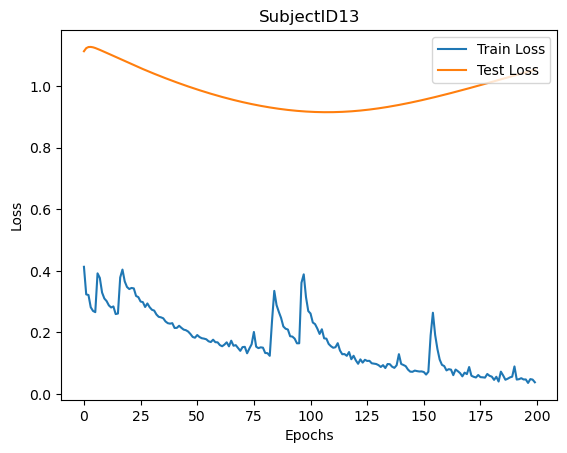

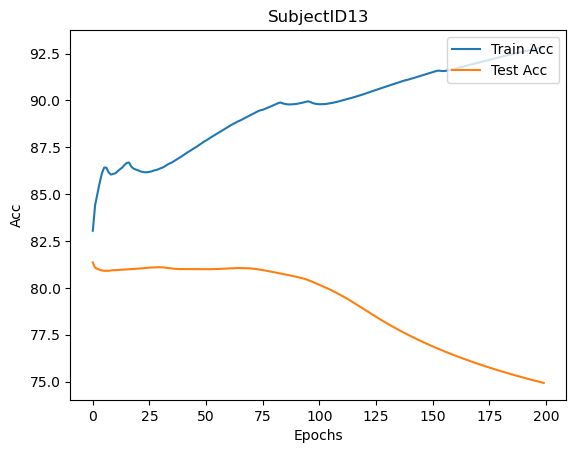


Subject 14
device: cuda
| epoch   0 | 0.1359 s/epoch | train loss 0.4958
| epoch   1 | 0.1357 s/epoch | train loss 0.4009
| epoch   2 | 0.1357 s/epoch | train loss 0.4803
| epoch   3 | 0.1358 s/epoch | train loss 0.4006
| epoch   4 | 0.1358 s/epoch | train loss 0.4222
| epoch   5 | 0.1358 s/epoch | train loss 0.3972
| epoch   6 | 0.1361 s/epoch | train loss 0.3278
| epoch   7 | 0.1357 s/epoch | train loss 0.3171
| epoch   8 | 0.1357 s/epoch | train loss 0.4410
| epoch   9 | 0.1357 s/epoch | train loss 0.3272
| epoch  10 | 0.1358 s/epoch | train loss 0.3620
| epoch  11 | 0.1356 s/epoch | train loss 0.4125
| epoch  12 | 0.1356 s/epoch | train loss 0.3758
| epoch  13 | 0.1358 s/epoch | train loss 0.4323
| epoch  14 | 0.1360 s/epoch | train loss 0.4205
| epoch  15 | 0.1360 s/epoch | train loss 0.4274
| epoch  16 | 0.1358 s/epoch | train loss 0.4214
| epoch  17 | 0.1357 s/epoch | train loss 0.3527
| epoch  18 | 0.1356 s/epoch | train loss 0.3208
| epoch  19 | 0.1356 s/epoch | train loss 0.

| epoch 167 | 0.1363 s/epoch | train loss 0.2366
| epoch 168 | 0.1363 s/epoch | train loss 0.2149
| epoch 169 | 0.1365 s/epoch | train loss 0.2114
| epoch 170 | 0.1361 s/epoch | train loss 0.2160
| epoch 171 | 0.1361 s/epoch | train loss 0.2296
| epoch 172 | 0.1364 s/epoch | train loss 0.3774
| epoch 173 | 0.1366 s/epoch | train loss 0.3152
| epoch 174 | 0.1363 s/epoch | train loss 0.2754
| epoch 175 | 0.1363 s/epoch | train loss 0.2659
| epoch 176 | 0.1364 s/epoch | train loss 0.2571
| epoch 177 | 0.1363 s/epoch | train loss 0.2571
| epoch 178 | 0.1363 s/epoch | train loss 0.2329
| epoch 179 | 0.1364 s/epoch | train loss 0.2235
| epoch 180 | 0.1364 s/epoch | train loss 0.2139
| epoch 181 | 0.1364 s/epoch | train loss 0.2237
| epoch 182 | 0.1363 s/epoch | train loss 0.2077
| epoch 183 | 0.1365 s/epoch | train loss 0.1995
| epoch 184 | 0.1363 s/epoch | train loss 0.1905
| epoch 185 | 0.1361 s/epoch | train loss 0.1825
| epoch 186 | 0.1363 s/epoch | train loss 0.1844
| epoch 187 | 0.1365

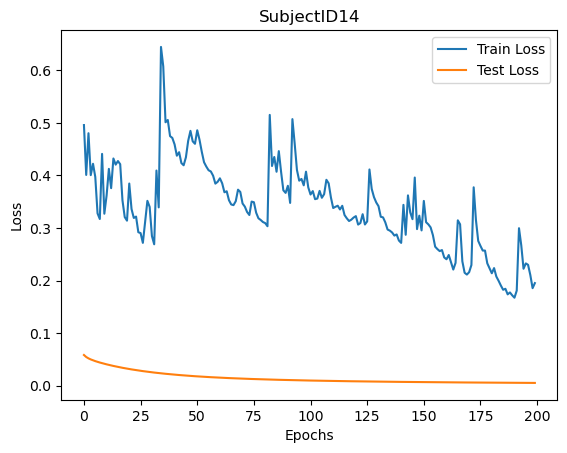

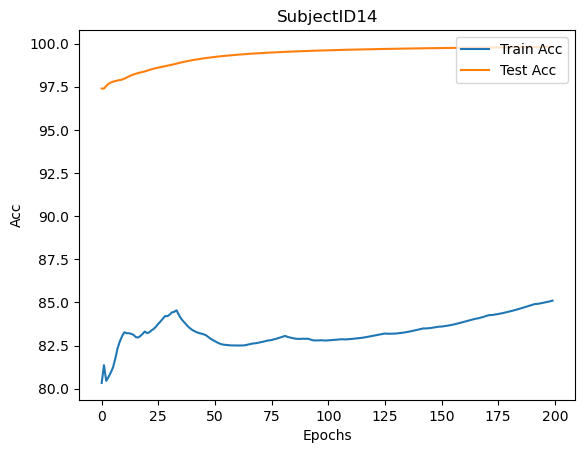

| epoch   0 | 0.1361 s/epoch | train loss 0.4844
| epoch   1 | 0.1360 s/epoch | train loss 0.3773
| epoch   2 | 0.1359 s/epoch | train loss 0.3985
| epoch   3 | 0.1359 s/epoch | train loss 0.3509
| epoch   4 | 0.1361 s/epoch | train loss 0.3708
| epoch   5 | 0.1361 s/epoch | train loss 0.3251
| epoch   6 | 0.1363 s/epoch | train loss 0.3061
| epoch   7 | 0.1362 s/epoch | train loss 0.2900
| epoch   8 | 0.1363 s/epoch | train loss 0.2886
| epoch   9 | 0.1361 s/epoch | train loss 0.3392
| epoch  10 | 0.1362 s/epoch | train loss 0.5185
| epoch  11 | 0.1360 s/epoch | train loss 0.4979
| epoch  12 | 0.1362 s/epoch | train loss 0.5478
| epoch  13 | 0.1361 s/epoch | train loss 0.4386
| epoch  14 | 0.1361 s/epoch | train loss 0.3727
| epoch  15 | 0.1362 s/epoch | train loss 0.3609
| epoch  16 | 0.1362 s/epoch | train loss 0.3557
| epoch  17 | 0.1363 s/epoch | train loss 0.3579
| epoch  18 | 0.1363 s/epoch | train loss 0.3513
| epoch  19 | 0.1361 s/epoch | train loss 0.3036
| epoch  20 | 0.1362

| epoch 168 | 0.1362 s/epoch | train loss 0.1258
| epoch 169 | 0.1364 s/epoch | train loss 0.1748
| epoch 170 | 0.1363 s/epoch | train loss 0.1292
| epoch 171 | 0.1364 s/epoch | train loss 0.1143
| epoch 172 | 0.1363 s/epoch | train loss 0.1349
| epoch 173 | 0.1364 s/epoch | train loss 0.1857
| epoch 174 | 0.1365 s/epoch | train loss 0.1409
| epoch 175 | 0.1364 s/epoch | train loss 0.1204
| epoch 176 | 0.1365 s/epoch | train loss 0.1521
| epoch 177 | 0.1365 s/epoch | train loss 0.1738
| epoch 178 | 0.1366 s/epoch | train loss 0.1215
| epoch 179 | 0.1364 s/epoch | train loss 0.1201
| epoch 180 | 0.1364 s/epoch | train loss 0.1064
| epoch 181 | 0.1364 s/epoch | train loss 0.1144
| epoch 182 | 0.1363 s/epoch | train loss 0.1411
| epoch 183 | 0.1361 s/epoch | train loss 0.1032
| epoch 184 | 0.1362 s/epoch | train loss 0.1096
| epoch 185 | 0.1362 s/epoch | train loss 0.0901
| epoch 186 | 0.1363 s/epoch | train loss 0.0901
| epoch 187 | 0.1361 s/epoch | train loss 0.1862
| epoch 188 | 0.1361

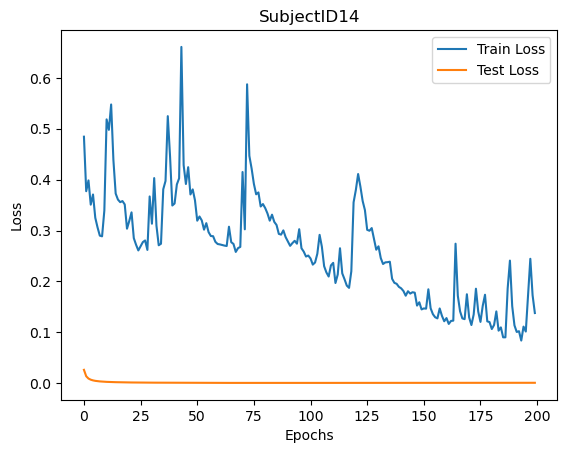

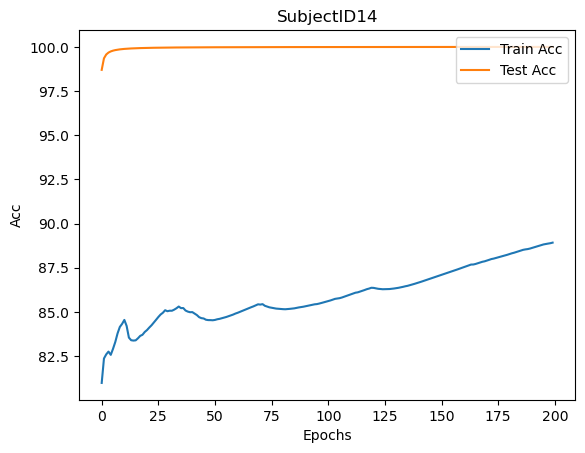


Subject 15
device: cuda
| epoch   0 | 0.1418 s/epoch | train loss 0.4783
| epoch   1 | 0.1412 s/epoch | train loss 0.3706
| epoch   2 | 0.1408 s/epoch | train loss 0.3175
| epoch   3 | 0.1412 s/epoch | train loss 0.3056
| epoch   4 | 0.1414 s/epoch | train loss 0.2836
| epoch   5 | 0.1412 s/epoch | train loss 0.2831
| epoch   6 | 0.1410 s/epoch | train loss 0.2582
| epoch   7 | 0.1411 s/epoch | train loss 0.2549
| epoch   8 | 0.1412 s/epoch | train loss 0.2436
| epoch   9 | 0.1412 s/epoch | train loss 0.2391
| epoch  10 | 0.1413 s/epoch | train loss 0.2330
| epoch  11 | 0.1415 s/epoch | train loss 0.2231
| epoch  12 | 0.1413 s/epoch | train loss 0.2272
| epoch  13 | 0.1411 s/epoch | train loss 0.2181
| epoch  14 | 0.1412 s/epoch | train loss 0.3278
| epoch  15 | 0.1412 s/epoch | train loss 0.2931
| epoch  16 | 0.1412 s/epoch | train loss 0.2571
| epoch  17 | 0.1413 s/epoch | train loss 0.2452
| epoch  18 | 0.1412 s/epoch | train loss 0.2292
| epoch  19 | 0.1413 s/epoch | train loss 0.

| epoch 167 | 0.1412 s/epoch | train loss 0.0382
| epoch 168 | 0.1413 s/epoch | train loss 0.0377
| epoch 169 | 0.1414 s/epoch | train loss 0.0408
| epoch 170 | 0.1416 s/epoch | train loss 0.0421
| epoch 171 | 0.1416 s/epoch | train loss 0.0327
| epoch 172 | 0.1414 s/epoch | train loss 0.0455
| epoch 173 | 0.1416 s/epoch | train loss 0.0260
| epoch 174 | 0.1415 s/epoch | train loss 0.0299
| epoch 175 | 0.1415 s/epoch | train loss 0.0351
| epoch 176 | 0.1416 s/epoch | train loss 0.0249
| epoch 177 | 0.1415 s/epoch | train loss 0.0345
| epoch 178 | 0.1416 s/epoch | train loss 0.0366
| epoch 179 | 0.1416 s/epoch | train loss 0.0345
| epoch 180 | 0.1417 s/epoch | train loss 0.0288
| epoch 181 | 0.1415 s/epoch | train loss 0.0315
| epoch 182 | 0.1417 s/epoch | train loss 0.0313
| epoch 183 | 0.1415 s/epoch | train loss 0.0304
| epoch 184 | 0.1414 s/epoch | train loss 0.0259
| epoch 185 | 0.1416 s/epoch | train loss 0.0368
| epoch 186 | 0.1415 s/epoch | train loss 0.0324
| epoch 187 | 0.1416

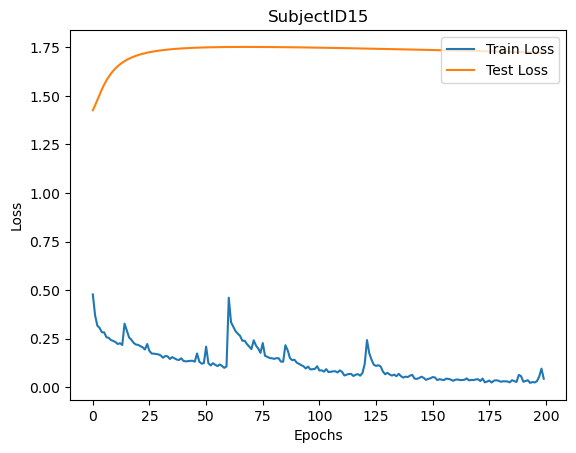

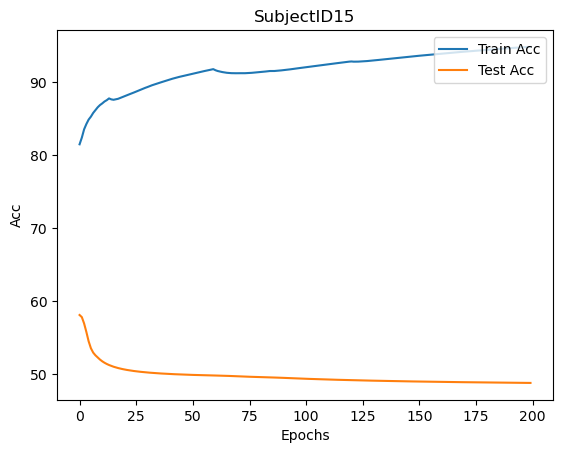

| epoch   0 | 0.1414 s/epoch | train loss 0.4245
| epoch   1 | 0.1413 s/epoch | train loss 0.3235
| epoch   2 | 0.1414 s/epoch | train loss 0.2994
| epoch   3 | 0.1413 s/epoch | train loss 0.2814
| epoch   4 | 0.1413 s/epoch | train loss 0.2695
| epoch   5 | 0.1414 s/epoch | train loss 0.2617
| epoch   6 | 0.1411 s/epoch | train loss 0.3346
| epoch   7 | 0.1410 s/epoch | train loss 0.3215
| epoch   8 | 0.1411 s/epoch | train loss 0.3042
| epoch   9 | 0.1412 s/epoch | train loss 0.2828
| epoch  10 | 0.1413 s/epoch | train loss 0.2781
| epoch  11 | 0.1413 s/epoch | train loss 0.2595
| epoch  12 | 0.1413 s/epoch | train loss 0.2603
| epoch  13 | 0.1414 s/epoch | train loss 0.2715
| epoch  14 | 0.1413 s/epoch | train loss 0.3377
| epoch  15 | 0.1412 s/epoch | train loss 0.2652
| epoch  16 | 0.1412 s/epoch | train loss 0.2459
| epoch  17 | 0.1413 s/epoch | train loss 0.2392
| epoch  18 | 0.1414 s/epoch | train loss 0.2278
| epoch  19 | 0.1411 s/epoch | train loss 0.2203
| epoch  20 | 0.1413

| epoch 168 | 0.1413 s/epoch | train loss 0.0482
| epoch 169 | 0.1415 s/epoch | train loss 0.0364
| epoch 170 | 0.1413 s/epoch | train loss 0.0296
| epoch 171 | 0.1412 s/epoch | train loss 0.0372
| epoch 172 | 0.1413 s/epoch | train loss 0.0344
| epoch 173 | 0.1415 s/epoch | train loss 0.0283
| epoch 174 | 0.1415 s/epoch | train loss 0.0437
| epoch 175 | 0.1414 s/epoch | train loss 0.0304
| epoch 176 | 0.1413 s/epoch | train loss 0.0194
| epoch 177 | 0.1412 s/epoch | train loss 0.0390
| epoch 178 | 0.1411 s/epoch | train loss 0.0216
| epoch 179 | 0.1410 s/epoch | train loss 0.0289
| epoch 180 | 0.1412 s/epoch | train loss 0.0337
| epoch 181 | 0.1410 s/epoch | train loss 0.0404
| epoch 182 | 0.1408 s/epoch | train loss 0.0386
| epoch 183 | 0.1410 s/epoch | train loss 0.0286
| epoch 184 | 0.1408 s/epoch | train loss 0.0280
| epoch 185 | 0.1410 s/epoch | train loss 0.0350
| epoch 186 | 0.1412 s/epoch | train loss 0.0263
| epoch 187 | 0.1413 s/epoch | train loss 0.0220
| epoch 188 | 0.1416

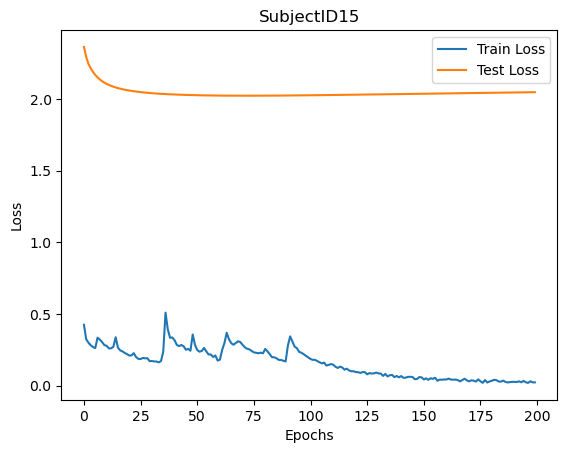

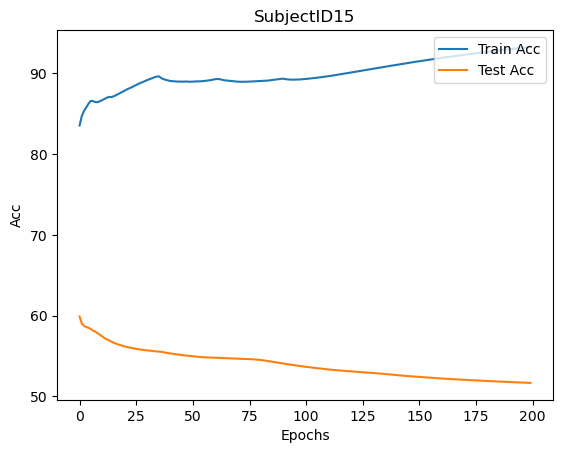

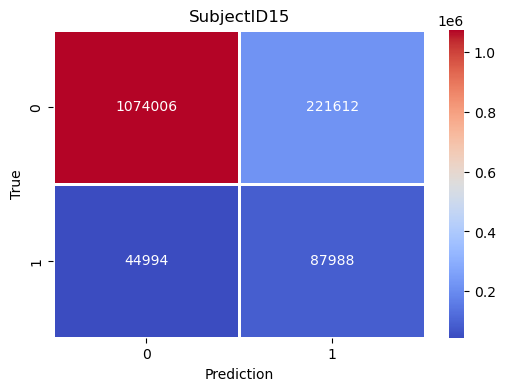

<Figure size 640x480 with 0 Axes>

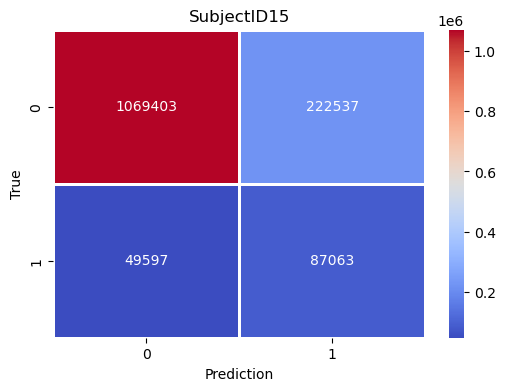

Teacher(RestNet50)_Acc: 0.8133795324093518
Teacher(RestNet50)_Rec: 0.661653456858823
Teacher(RestNet50)_Pre: 0.28419896640826875
Teacher(RestNet50)_F1: 0.3976121938985318
Original_Student(RestNet50)_Acc: 0.809510009799804
Original_Student(RestNet50)_Rec: 0.6370774184106541
Original_Student(RestNet50)_Pre: 0.2812112403100775
Original_Student(RestNet50)_F1: 0.3901895755837404


<Figure size 640x480 with 0 Axes>

In [11]:
#%% Evaluation
def evaluation(pred,target):
    acu = accuracy_score(pred, target)
    rec = recall_score(pred, target)
    pre = precision_score(pred, target)
    f1 = f1_score(pred, target)  
    return np.array([acu, rec, pre, f1])

#%% Train
Accuracy_teacher = []
Recall_teacher = []
Precision_teacher = []
F1score_teacher = []

Accuracy_student = []
Recall_student = []
Precision_student = []
F1score_student = []

Accuracy_teacher_student = []
Recall_teacher_student = []
Precision_teacher_student = []
F1score_teacher_student = []


teacher_train_preds = []
teacher_train_gt = []


student_train_preds = []
student_train_gt = []


#for i in range(Average_times):
lis = [1,2,3,4,5,7,8,9,10,11,12,13,14,15]
for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i], axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i], axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i], axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i], axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)

            

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode
    ResNet = Net_Teacher(block, [3, 4, 23, 3], 1, 2)
    model_teacher = ResNet.to(device) 
    model_teacher.train()

    #model_student = Net_Student(config).to(device)
    ResNet_S = Net_Student(block, [3, 4, 23, 3], 1, 2)
    model_student = ResNet_S.to(device)
    model_student.train()
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher = torch.optim.Adam(model_teacher.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    optimizer_student = torch.optim.Adam(model_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Start training and testing Teacher and Student Model
    training_teacher(trainloader,optimizer_teacher,criterion,model_teacher,testloader)
    #testing_teacher(testloader,optimizer_teacher,criterion,model_teacher)
  
    training_student(trainloader,optimizer_student,criterion,model_student,testloader)    
    #testing_student(testloader,optimizer_student,criterion,model_student)

Teacher_eval_table = evaluation(teacher_train_preds, teacher_train_gt)

Student_eval_table = evaluation(student_train_preds, student_train_gt)

show_CM_teacher(teacher_train_preds, teacher_train_gt)
show_CM_student(student_train_preds, student_train_gt)

print("Teacher(RestNet50)_Acc:",Teacher_eval_table[0])
print("Teacher(RestNet50)_Rec:",Teacher_eval_table[1])
print("Teacher(RestNet50)_Pre:",Teacher_eval_table[2])
print("Teacher(RestNet50)_F1:",Teacher_eval_table[3])

print("Original_Student(RestNet50)_Acc:",Student_eval_table[0])
print("Original_Student(RestNet50)_Rec:",Student_eval_table[1])
print("Original_Student(RestNet50)_Pre:",Student_eval_table[2])
print("Original_Student(RestNet50)_F1:",Student_eval_table[3]) 



Subject 1
| epoch   0 | 0.2068 s/epoch | train loss 1.3144
| epoch   1 | 0.2045 s/epoch | train loss 0.9896
| epoch   2 | 0.2046 s/epoch | train loss 0.8973
| epoch   3 | 0.2045 s/epoch | train loss 0.8158
| epoch   4 | 0.2046 s/epoch | train loss 0.7877
| epoch   5 | 0.2044 s/epoch | train loss 1.1566
| epoch   6 | 0.2040 s/epoch | train loss 0.9872
| epoch   7 | 0.2043 s/epoch | train loss 0.9348
| epoch   8 | 0.2041 s/epoch | train loss 0.9050
| epoch   9 | 0.2043 s/epoch | train loss 0.9047
| epoch  10 | 0.2044 s/epoch | train loss 0.8045
| epoch  11 | 0.2046 s/epoch | train loss 0.7317
| epoch  12 | 0.2046 s/epoch | train loss 0.6847
| epoch  13 | 0.2043 s/epoch | train loss 0.6812
| epoch  14 | 0.2042 s/epoch | train loss 0.7850
| epoch  15 | 0.2045 s/epoch | train loss 0.6715
| epoch  16 | 0.2045 s/epoch | train loss 0.6219
| epoch  17 | 0.2047 s/epoch | train loss 0.6427
| epoch  18 | 0.2048 s/epoch | train loss 0.6262
| epoch  19 | 0.2047 s/epoch | train loss 0.5645
| epoch  

| epoch 167 | 0.2050 s/epoch | train loss 0.7870
| epoch 168 | 0.2050 s/epoch | train loss 0.7452
| epoch 169 | 0.2048 s/epoch | train loss 0.6634
| epoch 170 | 0.2048 s/epoch | train loss 0.6540
| epoch 171 | 0.2049 s/epoch | train loss 0.6138
| epoch 172 | 0.2047 s/epoch | train loss 0.5558
| epoch 173 | 0.2048 s/epoch | train loss 0.5278
| epoch 174 | 0.2049 s/epoch | train loss 0.5060
| epoch 175 | 0.2047 s/epoch | train loss 0.4944
| epoch 176 | 0.2050 s/epoch | train loss 0.4658
| epoch 177 | 0.2047 s/epoch | train loss 0.4722
| epoch 178 | 0.2050 s/epoch | train loss 0.4469
| epoch 179 | 0.2048 s/epoch | train loss 0.5052
| epoch 180 | 0.2049 s/epoch | train loss 0.4121
| epoch 181 | 0.2050 s/epoch | train loss 0.3828
| epoch 182 | 0.2049 s/epoch | train loss 0.3814
| epoch 183 | 0.2050 s/epoch | train loss 0.3731
| epoch 184 | 0.2049 s/epoch | train loss 0.3519
| epoch 185 | 0.2051 s/epoch | train loss 0.3451
| epoch 186 | 0.2050 s/epoch | train loss 0.3317
| epoch 187 | 0.2050

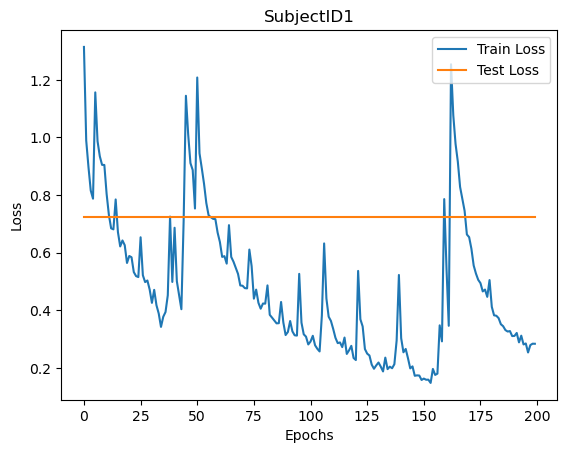

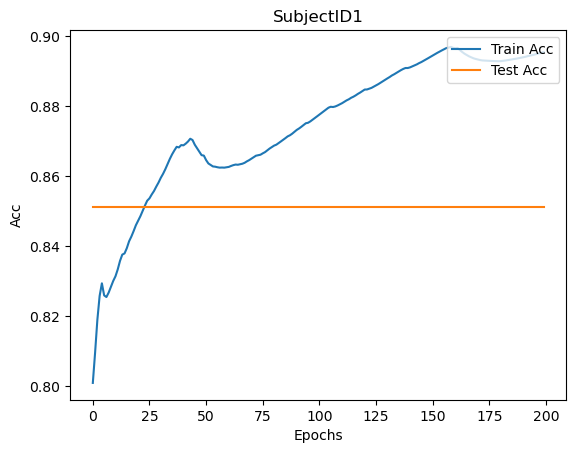


Subject 2
| epoch   0 | 0.1988 s/epoch | train loss 1.3356
| epoch   1 | 0.1988 s/epoch | train loss 1.0905
| epoch   2 | 0.1992 s/epoch | train loss 1.1830
| epoch   3 | 0.1993 s/epoch | train loss 1.0412
| epoch   4 | 0.1993 s/epoch | train loss 0.8974
| epoch   5 | 0.1991 s/epoch | train loss 0.8741
| epoch   6 | 0.1994 s/epoch | train loss 0.8726
| epoch   7 | 0.1991 s/epoch | train loss 0.7835
| epoch   8 | 0.1992 s/epoch | train loss 0.8882
| epoch   9 | 0.1994 s/epoch | train loss 0.7607
| epoch  10 | 0.1994 s/epoch | train loss 0.8845
| epoch  11 | 0.1994 s/epoch | train loss 0.9431
| epoch  12 | 0.1992 s/epoch | train loss 0.8368
| epoch  13 | 0.1999 s/epoch | train loss 0.7241
| epoch  14 | 0.1995 s/epoch | train loss 0.7459
| epoch  15 | 0.1992 s/epoch | train loss 0.6970
| epoch  16 | 0.1994 s/epoch | train loss 0.7142
| epoch  17 | 0.1992 s/epoch | train loss 0.8414
| epoch  18 | 0.1994 s/epoch | train loss 0.8218
| epoch  19 | 0.1991 s/epoch | train loss 0.7822
| epoch  

| epoch 167 | 0.1992 s/epoch | train loss 0.1730
| epoch 168 | 0.1991 s/epoch | train loss 0.1574
| epoch 169 | 0.1992 s/epoch | train loss 0.1795
| epoch 170 | 0.1991 s/epoch | train loss 0.1613
| epoch 171 | 0.1996 s/epoch | train loss 0.1425
| epoch 172 | 0.1999 s/epoch | train loss 0.1372
| epoch 173 | 0.1998 s/epoch | train loss 0.1499
| epoch 174 | 0.1999 s/epoch | train loss 0.1532
| epoch 175 | 0.1999 s/epoch | train loss 0.1564
| epoch 176 | 0.2000 s/epoch | train loss 0.9246
| epoch 177 | 0.1999 s/epoch | train loss 0.6529
| epoch 178 | 0.2001 s/epoch | train loss 0.5323
| epoch 179 | 0.1999 s/epoch | train loss 0.4690
| epoch 180 | 0.1995 s/epoch | train loss 0.4191
| epoch 181 | 0.1997 s/epoch | train loss 0.3925
| epoch 182 | 0.1998 s/epoch | train loss 0.3152
| epoch 183 | 0.1996 s/epoch | train loss 0.2877
| epoch 184 | 0.1998 s/epoch | train loss 0.3581
| epoch 185 | 0.1994 s/epoch | train loss 0.2697
| epoch 186 | 0.1997 s/epoch | train loss 0.2484
| epoch 187 | 0.1997

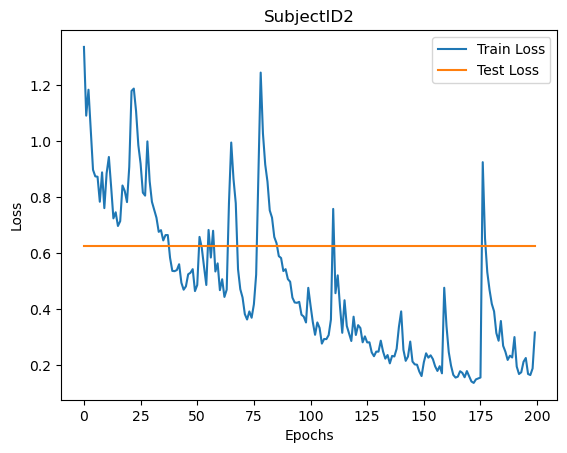

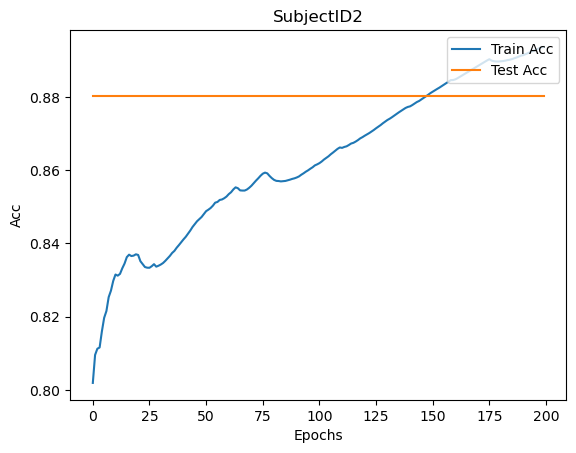


Subject 3
| epoch   0 | 0.1996 s/epoch | train loss 1.1854
| epoch   1 | 0.2000 s/epoch | train loss 0.9454
| epoch   2 | 0.1996 s/epoch | train loss 0.8521
| epoch   3 | 0.1995 s/epoch | train loss 0.7885
| epoch   4 | 0.1996 s/epoch | train loss 0.7901
| epoch   5 | 0.1997 s/epoch | train loss 0.7080
| epoch   6 | 0.1994 s/epoch | train loss 0.7528
| epoch   7 | 0.1995 s/epoch | train loss 0.6880
| epoch   8 | 0.1994 s/epoch | train loss 0.6956
| epoch   9 | 0.1995 s/epoch | train loss 0.6696
| epoch  10 | 0.1994 s/epoch | train loss 0.6599
| epoch  11 | 0.1993 s/epoch | train loss 0.5901
| epoch  12 | 0.1992 s/epoch | train loss 0.5741
| epoch  13 | 0.1990 s/epoch | train loss 0.5570
| epoch  14 | 0.1989 s/epoch | train loss 0.5918
| epoch  15 | 0.1992 s/epoch | train loss 0.5111
| epoch  16 | 0.1993 s/epoch | train loss 0.5366
| epoch  17 | 0.1992 s/epoch | train loss 0.4882
| epoch  18 | 0.1990 s/epoch | train loss 0.4729
| epoch  19 | 0.1991 s/epoch | train loss 0.5563
| epoch  

| epoch 167 | 0.4790 s/epoch | train loss 0.2732
| epoch 168 | 0.4825 s/epoch | train loss 0.2315
| epoch 169 | 0.4762 s/epoch | train loss 0.2617
| epoch 170 | 0.4508 s/epoch | train loss 0.5221
| epoch 171 | 0.4283 s/epoch | train loss 0.4073
| epoch 172 | 0.4254 s/epoch | train loss 0.3157
| epoch 173 | 0.4215 s/epoch | train loss 0.2649
| epoch 174 | 0.4472 s/epoch | train loss 0.2414
| epoch 175 | 0.4506 s/epoch | train loss 0.2067
| epoch 176 | 0.4499 s/epoch | train loss 0.2094
| epoch 177 | 0.4526 s/epoch | train loss 0.1818
| epoch 178 | 0.4507 s/epoch | train loss 0.1901
| epoch 179 | 0.4509 s/epoch | train loss 0.2192
| epoch 180 | 0.4527 s/epoch | train loss 0.1799
| epoch 181 | 0.4501 s/epoch | train loss 0.1983
| epoch 182 | 0.4513 s/epoch | train loss 0.1599
| epoch 183 | 0.4535 s/epoch | train loss 0.1591
| epoch 184 | 0.4495 s/epoch | train loss 0.1686
| epoch 185 | 0.4539 s/epoch | train loss 0.1603
| epoch 186 | 0.4548 s/epoch | train loss 0.1560
| epoch 187 | 0.4490

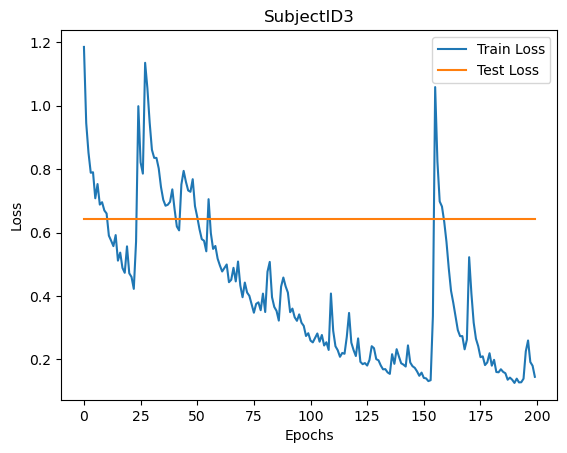

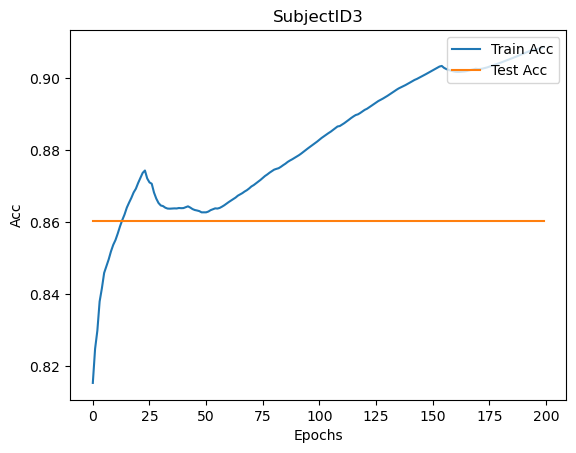


Subject 4
| epoch   0 | 0.4710 s/epoch | train loss 1.2938
| epoch   1 | 0.4717 s/epoch | train loss 1.0078
| epoch   2 | 0.4700 s/epoch | train loss 0.9158
| epoch   3 | 0.4729 s/epoch | train loss 0.9274
| epoch   4 | 0.4730 s/epoch | train loss 0.9235
| epoch   5 | 0.4716 s/epoch | train loss 0.8087
| epoch   6 | 0.4742 s/epoch | train loss 0.7393
| epoch   7 | 0.4752 s/epoch | train loss 0.6922
| epoch   8 | 0.4759 s/epoch | train loss 0.6748
| epoch   9 | 0.4747 s/epoch | train loss 0.6637
| epoch  10 | 0.4736 s/epoch | train loss 0.6182
| epoch  11 | 0.4727 s/epoch | train loss 0.5677
| epoch  12 | 0.4719 s/epoch | train loss 0.5575
| epoch  13 | 0.4737 s/epoch | train loss 0.5341
| epoch  14 | 0.4711 s/epoch | train loss 0.5386
| epoch  15 | 0.4735 s/epoch | train loss 0.5420
| epoch  16 | 0.4735 s/epoch | train loss 0.5451
| epoch  17 | 0.4739 s/epoch | train loss 0.5332
| epoch  18 | 0.4736 s/epoch | train loss 0.4739
| epoch  19 | 0.4713 s/epoch | train loss 0.5074
| epoch  

| epoch 167 | 0.4445 s/epoch | train loss 0.1352
| epoch 168 | 0.4471 s/epoch | train loss 0.1146
| epoch 169 | 0.4493 s/epoch | train loss 0.1128
| epoch 170 | 0.4497 s/epoch | train loss 0.1134
| epoch 171 | 0.4469 s/epoch | train loss 0.1071
| epoch 172 | 0.4657 s/epoch | train loss 0.1054
| epoch 173 | 0.4848 s/epoch | train loss 0.1039
| epoch 174 | 0.4824 s/epoch | train loss 0.1373
| epoch 175 | 0.4830 s/epoch | train loss 0.1286
| epoch 176 | 0.4890 s/epoch | train loss 0.1212
| epoch 177 | 0.4963 s/epoch | train loss 0.1537
| epoch 178 | 0.4666 s/epoch | train loss 0.2195
| epoch 179 | 0.4604 s/epoch | train loss 0.2053
| epoch 180 | 0.4618 s/epoch | train loss 0.1690
| epoch 181 | 0.4640 s/epoch | train loss 0.1427
| epoch 182 | 0.4635 s/epoch | train loss 0.1156
| epoch 183 | 0.4618 s/epoch | train loss 0.1075
| epoch 184 | 0.4576 s/epoch | train loss 0.0970
| epoch 185 | 0.4598 s/epoch | train loss 0.0989
| epoch 186 | 0.4601 s/epoch | train loss 0.0994
| epoch 187 | 0.4628

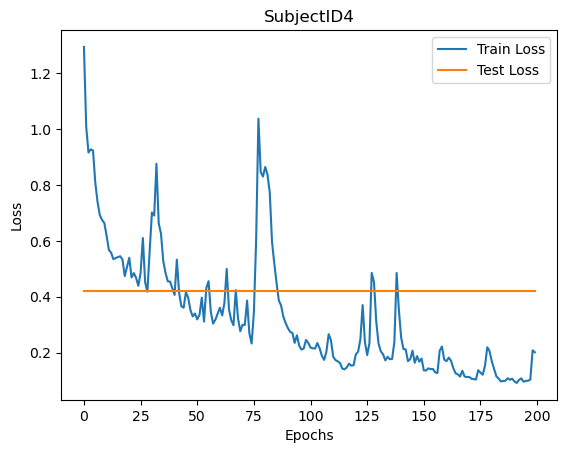

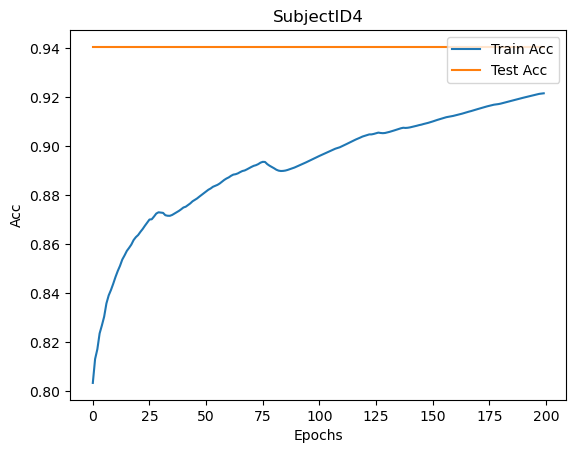


Subject 5
| epoch   0 | 0.4623 s/epoch | train loss 1.2825
| epoch   1 | 0.4632 s/epoch | train loss 0.9963
| epoch   2 | 0.4677 s/epoch | train loss 0.9180
| epoch   3 | 0.4627 s/epoch | train loss 0.8585
| epoch   4 | 0.4635 s/epoch | train loss 0.7836
| epoch   5 | 0.4625 s/epoch | train loss 0.7612
| epoch   6 | 0.4622 s/epoch | train loss 0.7039
| epoch   7 | 0.4640 s/epoch | train loss 0.7114
| epoch   8 | 0.4583 s/epoch | train loss 0.6753
| epoch   9 | 0.4645 s/epoch | train loss 0.6272
| epoch  10 | 0.4675 s/epoch | train loss 0.6153
| epoch  11 | 0.4779 s/epoch | train loss 0.6172
| epoch  12 | 0.4639 s/epoch | train loss 0.6000
| epoch  13 | 0.4628 s/epoch | train loss 0.5861
| epoch  14 | 0.4624 s/epoch | train loss 0.6461
| epoch  15 | 0.4629 s/epoch | train loss 0.5463
| epoch  16 | 0.4622 s/epoch | train loss 0.5169
| epoch  17 | 0.4618 s/epoch | train loss 0.5113
| epoch  18 | 0.4619 s/epoch | train loss 0.6151
| epoch  19 | 0.4600 s/epoch | train loss 0.8205
| epoch  

| epoch 167 | 0.4594 s/epoch | train loss 0.2052
| epoch 168 | 0.4563 s/epoch | train loss 0.1626
| epoch 169 | 0.4515 s/epoch | train loss 0.1472
| epoch 170 | 0.4521 s/epoch | train loss 0.1180
| epoch 171 | 0.4507 s/epoch | train loss 0.1113
| epoch 172 | 0.4501 s/epoch | train loss 0.1063
| epoch 173 | 0.4479 s/epoch | train loss 0.0990
| epoch 174 | 0.4526 s/epoch | train loss 0.0941
| epoch 175 | 0.4529 s/epoch | train loss 0.0978
| epoch 176 | 0.4509 s/epoch | train loss 0.0970
| epoch 177 | 0.4510 s/epoch | train loss 0.0926
| epoch 178 | 0.4510 s/epoch | train loss 0.0922
| epoch 179 | 0.4517 s/epoch | train loss 0.0910
| epoch 180 | 0.4417 s/epoch | train loss 0.0965
| epoch 181 | 0.4146 s/epoch | train loss 0.0970
| epoch 182 | 0.4155 s/epoch | train loss 0.1021
| epoch 183 | 0.4126 s/epoch | train loss 0.1094
| epoch 184 | 0.4181 s/epoch | train loss 0.2131
| epoch 185 | 0.4164 s/epoch | train loss 0.2320
| epoch 186 | 0.4197 s/epoch | train loss 0.1723
| epoch 187 | 0.4197

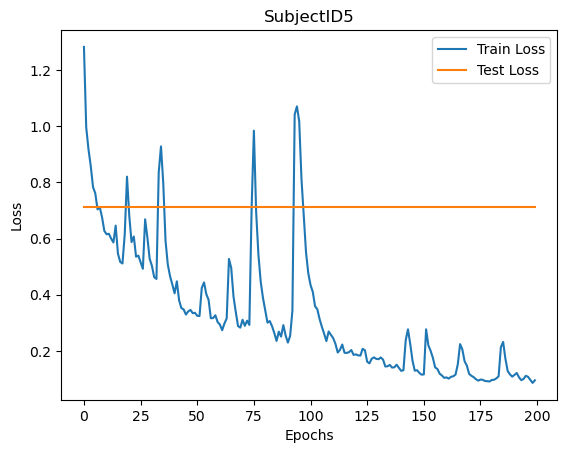

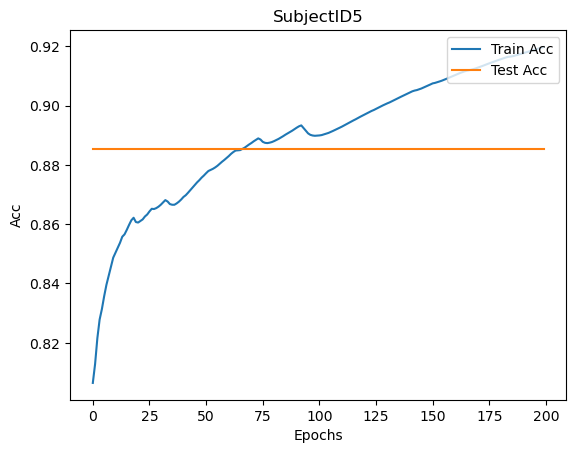


Subject 7
| epoch   0 | 0.4164 s/epoch | train loss 1.2859
| epoch   1 | 0.4196 s/epoch | train loss 0.8969
| epoch   2 | 0.4131 s/epoch | train loss 0.8684
| epoch   3 | 0.4166 s/epoch | train loss 0.8013
| epoch   4 | 0.4173 s/epoch | train loss 0.7858
| epoch   5 | 0.4148 s/epoch | train loss 0.7260
| epoch   6 | 0.4162 s/epoch | train loss 0.7462
| epoch   7 | 0.4164 s/epoch | train loss 0.6892
| epoch   8 | 0.4152 s/epoch | train loss 0.6462
| epoch   9 | 0.4347 s/epoch | train loss 0.6073
| epoch  10 | 0.4406 s/epoch | train loss 0.6014
| epoch  11 | 0.4411 s/epoch | train loss 0.5882
| epoch  12 | 0.4416 s/epoch | train loss 0.6112
| epoch  13 | 0.4443 s/epoch | train loss 0.5667
| epoch  14 | 0.4422 s/epoch | train loss 0.5622
| epoch  15 | 0.4424 s/epoch | train loss 0.5112
| epoch  16 | 0.4419 s/epoch | train loss 0.4855
| epoch  17 | 0.4420 s/epoch | train loss 0.5438
| epoch  18 | 0.4397 s/epoch | train loss 0.5622
| epoch  19 | 0.4423 s/epoch | train loss 0.5782
| epoch  

| epoch 167 | 0.4435 s/epoch | train loss 0.1055
| epoch 168 | 0.4422 s/epoch | train loss 0.1741
| epoch 169 | 0.4437 s/epoch | train loss 0.2277
| epoch 170 | 0.4416 s/epoch | train loss 0.1540
| epoch 171 | 0.4420 s/epoch | train loss 0.1414
| epoch 172 | 0.4393 s/epoch | train loss 0.1300
| epoch 173 | 0.4428 s/epoch | train loss 0.1382
| epoch 174 | 0.4435 s/epoch | train loss 0.1367
| epoch 175 | 0.4434 s/epoch | train loss 0.1759
| epoch 176 | 0.4416 s/epoch | train loss 0.2169
| epoch 177 | 0.4418 s/epoch | train loss 0.1277
| epoch 178 | 0.4420 s/epoch | train loss 0.1106
| epoch 179 | 0.4420 s/epoch | train loss 0.1078
| epoch 180 | 0.4455 s/epoch | train loss 0.1019
| epoch 181 | 0.4503 s/epoch | train loss 0.1008
| epoch 182 | 0.4543 s/epoch | train loss 0.1362
| epoch 183 | 0.4508 s/epoch | train loss 0.1447
| epoch 184 | 0.4528 s/epoch | train loss 0.1196
| epoch 185 | 0.4529 s/epoch | train loss 0.1464
| epoch 186 | 0.4500 s/epoch | train loss 0.1221
| epoch 187 | 0.4556

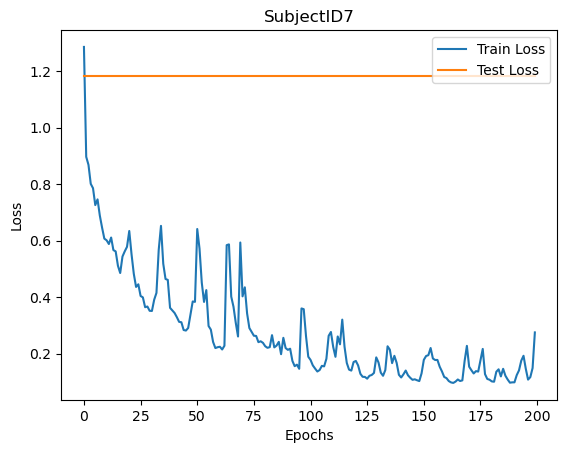

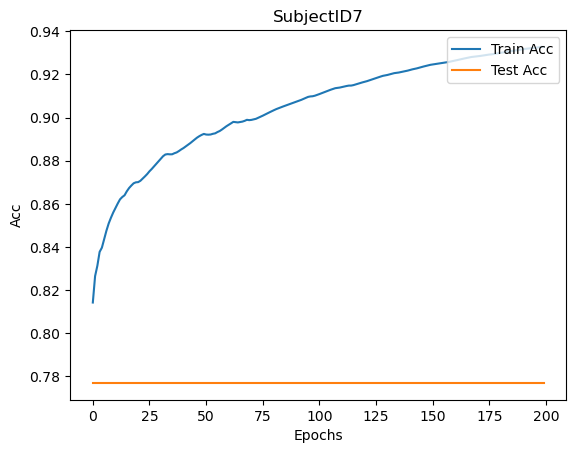


Subject 8
| epoch   0 | 0.4389 s/epoch | train loss 1.3796
| epoch   1 | 0.4600 s/epoch | train loss 1.0223
| epoch   2 | 0.4762 s/epoch | train loss 0.8969
| epoch   3 | 0.4723 s/epoch | train loss 0.8574
| epoch   4 | 0.4710 s/epoch | train loss 0.8310
| epoch   5 | 0.4766 s/epoch | train loss 0.7674
| epoch   6 | 0.4767 s/epoch | train loss 0.8221
| epoch   7 | 0.4776 s/epoch | train loss 0.6992
| epoch   8 | 0.4754 s/epoch | train loss 0.6793
| epoch   9 | 0.4732 s/epoch | train loss 0.6255
| epoch  10 | 0.4702 s/epoch | train loss 0.6341
| epoch  11 | 0.4789 s/epoch | train loss 0.7115
| epoch  12 | 0.4723 s/epoch | train loss 0.6056
| epoch  13 | 0.4746 s/epoch | train loss 0.5655
| epoch  14 | 0.4782 s/epoch | train loss 0.5335
| epoch  15 | 0.4731 s/epoch | train loss 0.5176
| epoch  16 | 0.4722 s/epoch | train loss 0.5106
| epoch  17 | 0.4748 s/epoch | train loss 0.5054
| epoch  18 | 0.4760 s/epoch | train loss 0.7450
| epoch  19 | 0.4691 s/epoch | train loss 0.5804
| epoch  

| epoch 167 | 0.4734 s/epoch | train loss 0.0989
| epoch 168 | 0.4721 s/epoch | train loss 0.0996
| epoch 169 | 0.4757 s/epoch | train loss 0.0948
| epoch 170 | 0.4728 s/epoch | train loss 0.0948
| epoch 171 | 0.4873 s/epoch | train loss 0.1005
| epoch 172 | 0.4749 s/epoch | train loss 0.4076
| epoch 173 | 0.4515 s/epoch | train loss 0.4285
| epoch 174 | 0.4477 s/epoch | train loss 0.2517
| epoch 175 | 0.4347 s/epoch | train loss 0.1739
| epoch 176 | 0.4366 s/epoch | train loss 0.1659
| epoch 177 | 0.4346 s/epoch | train loss 0.1325
| epoch 178 | 0.4338 s/epoch | train loss 0.1676
| epoch 179 | 0.4375 s/epoch | train loss 0.1319
| epoch 180 | 0.4382 s/epoch | train loss 0.1630
| epoch 181 | 0.4381 s/epoch | train loss 0.1548
| epoch 182 | 0.4378 s/epoch | train loss 0.1213
| epoch 183 | 0.4399 s/epoch | train loss 0.1179
| epoch 184 | 0.4628 s/epoch | train loss 0.0996
| epoch 185 | 0.4681 s/epoch | train loss 0.0938
| epoch 186 | 0.4653 s/epoch | train loss 0.0934
| epoch 187 | 0.4686

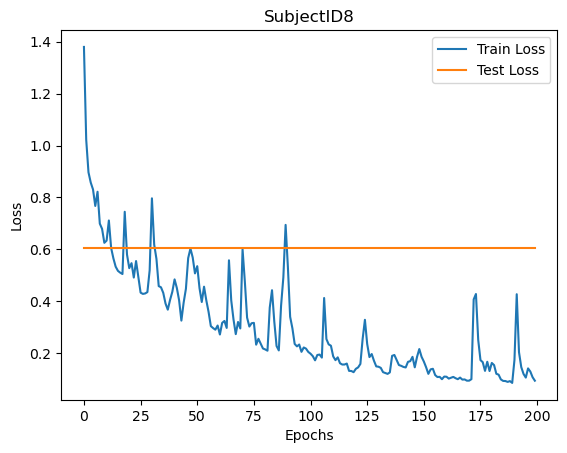

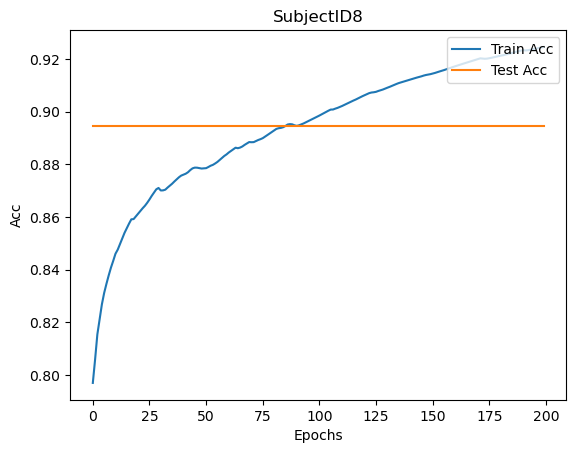


Subject 9
| epoch   0 | 0.4528 s/epoch | train loss 1.2882
| epoch   1 | 0.4563 s/epoch | train loss 0.9357
| epoch   2 | 0.4599 s/epoch | train loss 0.8603
| epoch   3 | 0.4550 s/epoch | train loss 0.7889
| epoch   4 | 0.4332 s/epoch | train loss 0.7275
| epoch   5 | 0.4188 s/epoch | train loss 0.6967
| epoch   6 | 0.4198 s/epoch | train loss 0.6813
| epoch   7 | 0.4179 s/epoch | train loss 0.6562
| epoch   8 | 0.4162 s/epoch | train loss 0.5868
| epoch   9 | 0.4207 s/epoch | train loss 0.6137
| epoch  10 | 0.4193 s/epoch | train loss 0.6187
| epoch  11 | 0.4176 s/epoch | train loss 0.5539
| epoch  12 | 0.4219 s/epoch | train loss 0.5226
| epoch  13 | 0.4554 s/epoch | train loss 0.4868
| epoch  14 | 0.4505 s/epoch | train loss 0.4934
| epoch  15 | 0.4548 s/epoch | train loss 0.4680
| epoch  16 | 0.4570 s/epoch | train loss 0.4873
| epoch  17 | 0.4530 s/epoch | train loss 0.5200
| epoch  18 | 0.4537 s/epoch | train loss 0.4277
| epoch  19 | 0.4581 s/epoch | train loss 0.4320
| epoch  

| epoch 167 | 0.4527 s/epoch | train loss 0.0984
| epoch 168 | 0.4527 s/epoch | train loss 0.0916
| epoch 169 | 0.4525 s/epoch | train loss 0.0902
| epoch 170 | 0.4536 s/epoch | train loss 0.1006
| epoch 171 | 0.4595 s/epoch | train loss 0.1010
| epoch 172 | 0.4581 s/epoch | train loss 0.1313
| epoch 173 | 0.4520 s/epoch | train loss 0.2037
| epoch 174 | 0.4549 s/epoch | train loss 0.2659
| epoch 175 | 0.4584 s/epoch | train loss 0.1791
| epoch 176 | 0.4572 s/epoch | train loss 0.1374
| epoch 177 | 0.4545 s/epoch | train loss 0.1755
| epoch 178 | 0.4557 s/epoch | train loss 0.1646
| epoch 179 | 0.4550 s/epoch | train loss 0.1271
| epoch 180 | 0.4535 s/epoch | train loss 0.1897
| epoch 181 | 0.4566 s/epoch | train loss 0.1214
| epoch 182 | 0.4576 s/epoch | train loss 0.1007
| epoch 183 | 0.4539 s/epoch | train loss 0.0951
| epoch 184 | 0.4636 s/epoch | train loss 0.0933
| epoch 185 | 0.4620 s/epoch | train loss 0.0940
| epoch 186 | 0.4618 s/epoch | train loss 0.1249
| epoch 187 | 0.4646

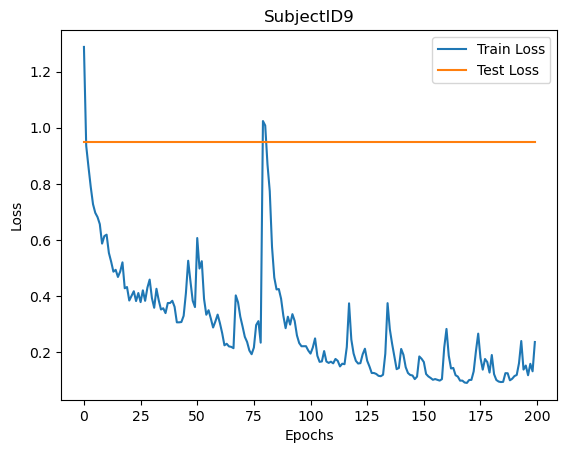

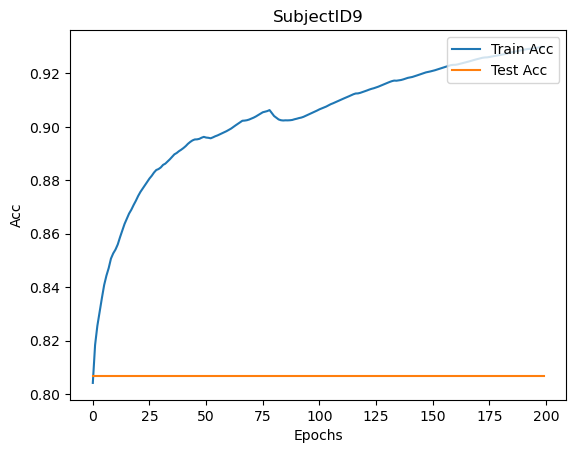


Subject 10
| epoch   0 | 0.4560 s/epoch | train loss 1.3471
| epoch   1 | 0.4565 s/epoch | train loss 0.9963
| epoch   2 | 0.4792 s/epoch | train loss 0.9510
| epoch   3 | 0.4789 s/epoch | train loss 0.8275
| epoch   4 | 0.4813 s/epoch | train loss 0.7787
| epoch   5 | 0.4790 s/epoch | train loss 0.7875
| epoch   6 | 0.4788 s/epoch | train loss 0.7431
| epoch   7 | 0.4797 s/epoch | train loss 0.7117
| epoch   8 | 0.4790 s/epoch | train loss 0.6653
| epoch   9 | 0.4828 s/epoch | train loss 0.7327
| epoch  10 | 0.4864 s/epoch | train loss 0.6657
| epoch  11 | 0.4835 s/epoch | train loss 0.6414
| epoch  12 | 0.4825 s/epoch | train loss 0.6180
| epoch  13 | 0.4817 s/epoch | train loss 0.6581
| epoch  14 | 0.4825 s/epoch | train loss 0.6232
| epoch  15 | 0.4832 s/epoch | train loss 0.5578
| epoch  16 | 0.4896 s/epoch | train loss 0.5392
| epoch  17 | 0.4854 s/epoch | train loss 0.5701
| epoch  18 | 0.4496 s/epoch | train loss 0.4914
| epoch  19 | 0.4492 s/epoch | train loss 0.5236
| epoch 

| epoch 167 | 0.5270 s/epoch | train loss 0.1207
| epoch 168 | 0.5518 s/epoch | train loss 0.1415
| epoch 169 | 0.5506 s/epoch | train loss 0.1486
| epoch 170 | 0.5400 s/epoch | train loss 0.1635
| epoch 171 | 0.5820 s/epoch | train loss 0.1990
| epoch 172 | 0.6119 s/epoch | train loss 0.2135
| epoch 173 | 0.6167 s/epoch | train loss 0.2406
| epoch 174 | 0.7029 s/epoch | train loss 0.2032
| epoch 175 | 0.9656 s/epoch | train loss 0.1679
| epoch 176 | 0.5864 s/epoch | train loss 0.1758
| epoch 177 | 0.5733 s/epoch | train loss 0.1754
| epoch 178 | 0.5947 s/epoch | train loss 0.1562
| epoch 179 | 0.6072 s/epoch | train loss 0.1137
| epoch 180 | 0.6211 s/epoch | train loss 0.1130
| epoch 181 | 0.6007 s/epoch | train loss 0.1229
| epoch 182 | 0.6205 s/epoch | train loss 0.1225
| epoch 183 | 0.5932 s/epoch | train loss 0.1497
| epoch 184 | 0.6160 s/epoch | train loss 0.1206
| epoch 185 | 0.6033 s/epoch | train loss 0.1107
| epoch 186 | 0.5083 s/epoch | train loss 0.0984
| epoch 187 | 0.5107

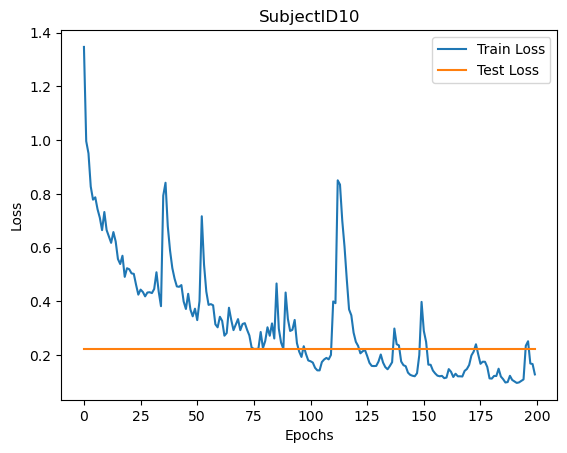

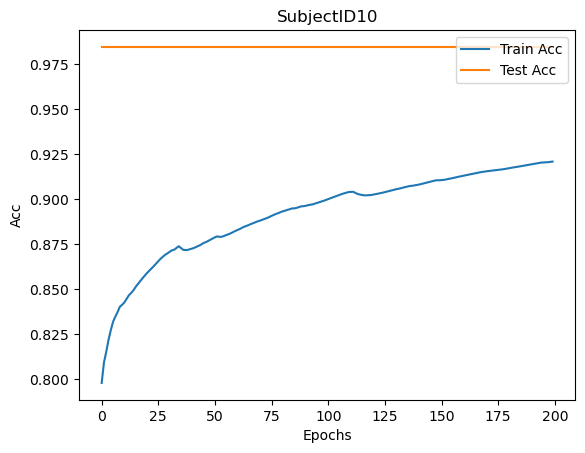


Subject 11
| epoch   0 | 0.6208 s/epoch | train loss 1.3585
| epoch   1 | 0.6080 s/epoch | train loss 1.0198
| epoch   2 | 0.6113 s/epoch | train loss 0.9655
| epoch   3 | 0.5938 s/epoch | train loss 0.9643
| epoch   4 | 0.6176 s/epoch | train loss 0.8178
| epoch   5 | 0.6320 s/epoch | train loss 0.8119
| epoch   6 | 0.6124 s/epoch | train loss 0.7508
| epoch   7 | 0.5967 s/epoch | train loss 0.7230
| epoch   8 | 0.5097 s/epoch | train loss 0.7006
| epoch   9 | 0.5104 s/epoch | train loss 0.6548
| epoch  10 | 0.5100 s/epoch | train loss 0.6304
| epoch  11 | 0.5126 s/epoch | train loss 0.6150
| epoch  12 | 0.4894 s/epoch | train loss 0.5882
| epoch  13 | 0.4784 s/epoch | train loss 0.5700
| epoch  14 | 0.4793 s/epoch | train loss 0.5335
| epoch  15 | 0.4885 s/epoch | train loss 0.5778
| epoch  16 | 0.4814 s/epoch | train loss 0.6222
| epoch  17 | 0.4832 s/epoch | train loss 0.5603
| epoch  18 | 0.4864 s/epoch | train loss 0.5736
| epoch  19 | 0.4849 s/epoch | train loss 0.5030
| epoch 

| epoch 167 | 0.4545 s/epoch | train loss 0.1048
| epoch 168 | 0.4179 s/epoch | train loss 0.1017
| epoch 169 | 0.4846 s/epoch | train loss 0.1092
| epoch 170 | 0.4826 s/epoch | train loss 0.1059
| epoch 171 | 0.4815 s/epoch | train loss 0.1081
| epoch 172 | 0.4853 s/epoch | train loss 0.1216
| epoch 173 | 0.4849 s/epoch | train loss 0.2058
| epoch 174 | 0.4836 s/epoch | train loss 0.1969
| epoch 175 | 0.4848 s/epoch | train loss 0.1425
| epoch 176 | 0.4854 s/epoch | train loss 0.1186
| epoch 177 | 0.4833 s/epoch | train loss 0.1205
| epoch 178 | 0.4804 s/epoch | train loss 0.1674
| epoch 179 | 0.4825 s/epoch | train loss 0.1916
| epoch 180 | 0.4851 s/epoch | train loss 0.2555
| epoch 181 | 0.4844 s/epoch | train loss 0.1757
| epoch 182 | 0.4829 s/epoch | train loss 0.1399
| epoch 183 | 0.4868 s/epoch | train loss 0.1399
| epoch 184 | 0.4821 s/epoch | train loss 0.1234
| epoch 185 | 0.4850 s/epoch | train loss 0.1178
| epoch 186 | 0.4829 s/epoch | train loss 0.2136
| epoch 187 | 0.4862

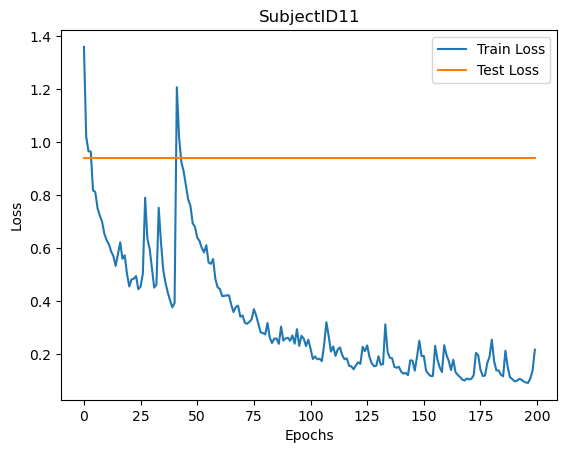

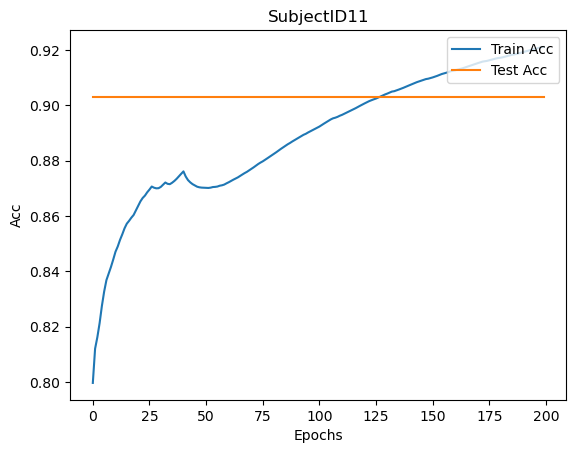


Subject 12
| epoch   0 | 0.4598 s/epoch | train loss 1.3678
| epoch   1 | 0.4632 s/epoch | train loss 1.0650
| epoch   2 | 0.4619 s/epoch | train loss 0.9617
| epoch   3 | 0.4576 s/epoch | train loss 0.9276
| epoch   4 | 0.4539 s/epoch | train loss 0.8283
| epoch   5 | 0.4613 s/epoch | train loss 0.8331
| epoch   6 | 0.4589 s/epoch | train loss 0.7665
| epoch   7 | 0.4590 s/epoch | train loss 0.8405
| epoch   8 | 0.4620 s/epoch | train loss 0.7688
| epoch   9 | 0.4630 s/epoch | train loss 0.7691
| epoch  10 | 0.4609 s/epoch | train loss 0.6939
| epoch  11 | 0.4607 s/epoch | train loss 0.6766
| epoch  12 | 0.4591 s/epoch | train loss 0.6867
| epoch  13 | 0.4613 s/epoch | train loss 0.6700
| epoch  14 | 0.4604 s/epoch | train loss 0.7643
| epoch  15 | 0.4633 s/epoch | train loss 0.6683
| epoch  16 | 0.4624 s/epoch | train loss 0.6985
| epoch  17 | 0.4581 s/epoch | train loss 0.7267
| epoch  18 | 0.4571 s/epoch | train loss 0.6246
| epoch  19 | 0.4594 s/epoch | train loss 0.5956
| epoch 

| epoch 167 | 0.4514 s/epoch | train loss 0.1421
| epoch 168 | 0.4512 s/epoch | train loss 0.1543
| epoch 169 | 0.4528 s/epoch | train loss 0.2575
| epoch 170 | 0.4504 s/epoch | train loss 0.1605
| epoch 171 | 0.4485 s/epoch | train loss 0.1503
| epoch 172 | 0.4505 s/epoch | train loss 0.1243
| epoch 173 | 0.4501 s/epoch | train loss 0.1423
| epoch 174 | 0.4505 s/epoch | train loss 0.1326
| epoch 175 | 0.4478 s/epoch | train loss 0.1143
| epoch 176 | 0.4500 s/epoch | train loss 0.1160
| epoch 177 | 0.4506 s/epoch | train loss 0.1183
| epoch 178 | 0.4490 s/epoch | train loss 0.1339
| epoch 179 | 0.4498 s/epoch | train loss 0.1217
| epoch 180 | 0.4475 s/epoch | train loss 0.1189
| epoch 181 | 0.4510 s/epoch | train loss 0.1145
| epoch 182 | 0.4522 s/epoch | train loss 0.1185
| epoch 183 | 0.4509 s/epoch | train loss 0.1101
| epoch 184 | 0.4531 s/epoch | train loss 0.1138
| epoch 185 | 0.4526 s/epoch | train loss 0.1071
| epoch 186 | 0.4490 s/epoch | train loss 0.1129
| epoch 187 | 0.4435

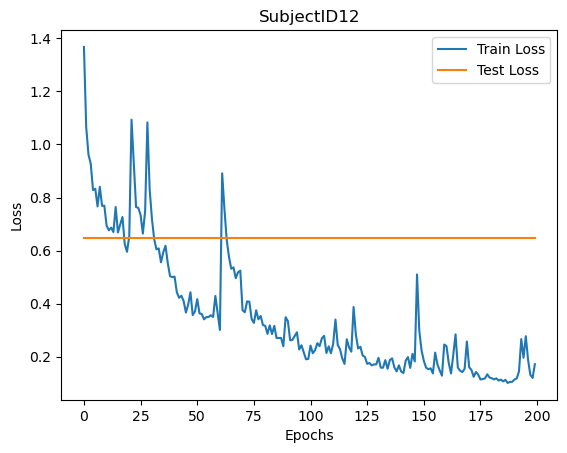

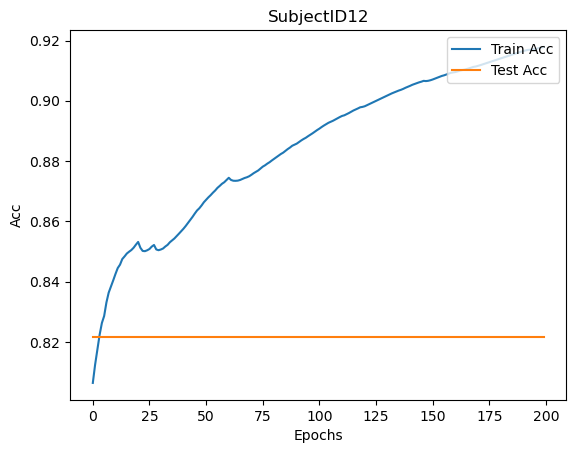


Subject 13
| epoch   0 | 0.4472 s/epoch | train loss 1.2538
| epoch   1 | 0.4493 s/epoch | train loss 1.0309
| epoch   2 | 0.4476 s/epoch | train loss 0.8971
| epoch   3 | 0.4495 s/epoch | train loss 0.8798
| epoch   4 | 0.4484 s/epoch | train loss 0.7981
| epoch   5 | 0.4517 s/epoch | train loss 0.7491
| epoch   6 | 0.4552 s/epoch | train loss 0.7432
| epoch   7 | 0.4502 s/epoch | train loss 0.7528
| epoch   8 | 0.4508 s/epoch | train loss 0.7005
| epoch   9 | 0.4506 s/epoch | train loss 0.6316
| epoch  10 | 0.4488 s/epoch | train loss 0.7277
| epoch  11 | 0.4457 s/epoch | train loss 0.8498
| epoch  12 | 0.4420 s/epoch | train loss 0.8054
| epoch  13 | 0.4502 s/epoch | train loss 0.7312
| epoch  14 | 0.4448 s/epoch | train loss 0.6733
| epoch  15 | 0.4439 s/epoch | train loss 0.7169
| epoch  16 | 0.4505 s/epoch | train loss 0.7770
| epoch  17 | 0.4504 s/epoch | train loss 0.7421
| epoch  18 | 0.4486 s/epoch | train loss 0.6497
| epoch  19 | 0.4503 s/epoch | train loss 0.5947
| epoch 

| epoch 167 | 0.4497 s/epoch | train loss 0.1347
| epoch 168 | 0.4488 s/epoch | train loss 0.1241
| epoch 169 | 0.4528 s/epoch | train loss 0.1370
| epoch 170 | 0.4470 s/epoch | train loss 0.1378
| epoch 171 | 0.4543 s/epoch | train loss 0.1602
| epoch 172 | 0.4558 s/epoch | train loss 0.1628
| epoch 173 | 0.4544 s/epoch | train loss 0.1423
| epoch 174 | 0.4548 s/epoch | train loss 0.1382
| epoch 175 | 0.4569 s/epoch | train loss 0.1279
| epoch 176 | 0.4560 s/epoch | train loss 0.1354
| epoch 177 | 0.4536 s/epoch | train loss 0.1553
| epoch 178 | 0.4603 s/epoch | train loss 0.1957
| epoch 179 | 0.4567 s/epoch | train loss 0.1704
| epoch 180 | 0.4576 s/epoch | train loss 0.1741
| epoch 181 | 0.4562 s/epoch | train loss 0.1752
| epoch 182 | 0.4585 s/epoch | train loss 0.1885
| epoch 183 | 0.4530 s/epoch | train loss 0.1681
| epoch 184 | 0.4544 s/epoch | train loss 0.1263
| epoch 185 | 0.4568 s/epoch | train loss 0.1429
| epoch 186 | 0.4561 s/epoch | train loss 0.1223
| epoch 187 | 0.4588

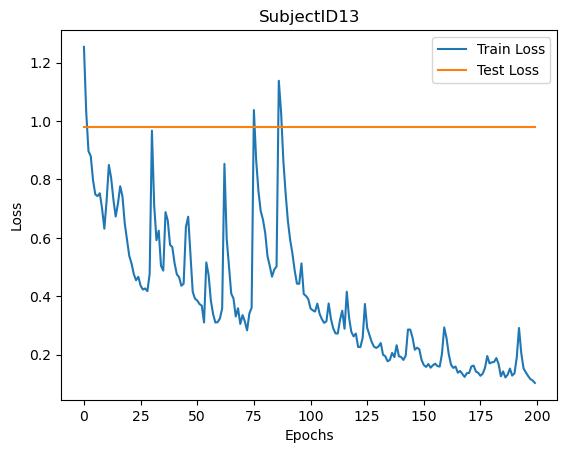

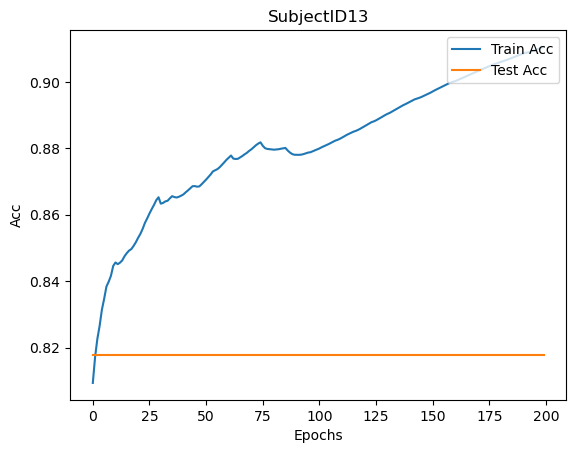


Subject 14
| epoch   0 | 0.4760 s/epoch | train loss 1.3698
| epoch   1 | 0.4735 s/epoch | train loss 1.3489
| epoch   2 | 0.4781 s/epoch | train loss 1.1457
| epoch   3 | 0.4762 s/epoch | train loss 0.9391
| epoch   4 | 0.4769 s/epoch | train loss 0.8801
| epoch   5 | 0.4746 s/epoch | train loss 1.1084
| epoch   6 | 0.4735 s/epoch | train loss 1.0205
| epoch   7 | 0.4729 s/epoch | train loss 0.8682
| epoch   8 | 0.4743 s/epoch | train loss 0.8685
| epoch   9 | 0.4776 s/epoch | train loss 0.8118
| epoch  10 | 0.4768 s/epoch | train loss 0.7814
| epoch  11 | 0.4773 s/epoch | train loss 0.9115
| epoch  12 | 0.4815 s/epoch | train loss 0.8004
| epoch  13 | 0.4768 s/epoch | train loss 0.7845
| epoch  14 | 0.4724 s/epoch | train loss 0.6530
| epoch  15 | 0.4757 s/epoch | train loss 0.5895
| epoch  16 | 0.4746 s/epoch | train loss 0.5907
| epoch  17 | 0.4762 s/epoch | train loss 0.5642
| epoch  18 | 0.4721 s/epoch | train loss 0.5505
| epoch  19 | 0.4703 s/epoch | train loss 0.7979
| epoch 

| epoch 167 | 0.4671 s/epoch | train loss 0.1796
| epoch 168 | 0.4639 s/epoch | train loss 0.1613
| epoch 169 | 0.4625 s/epoch | train loss 0.1455
| epoch 170 | 0.4702 s/epoch | train loss 0.1420
| epoch 171 | 0.4645 s/epoch | train loss 0.1702
| epoch 172 | 0.4648 s/epoch | train loss 0.6763
| epoch 173 | 0.4654 s/epoch | train loss 0.3742
| epoch 174 | 0.4661 s/epoch | train loss 0.2984
| epoch 175 | 0.4637 s/epoch | train loss 0.2846
| epoch 176 | 0.4641 s/epoch | train loss 0.2209
| epoch 177 | 0.4572 s/epoch | train loss 0.2069
| epoch 178 | 0.4664 s/epoch | train loss 0.2006
| epoch 179 | 0.4673 s/epoch | train loss 0.1656
| epoch 180 | 0.4643 s/epoch | train loss 0.2153
| epoch 181 | 0.4652 s/epoch | train loss 0.1698
| epoch 182 | 0.4627 s/epoch | train loss 0.1432
| epoch 183 | 0.4623 s/epoch | train loss 0.1499
| epoch 184 | 0.4690 s/epoch | train loss 0.1585
| epoch 185 | 0.4661 s/epoch | train loss 0.3567
| epoch 186 | 0.4643 s/epoch | train loss 0.2400
| epoch 187 | 0.4586

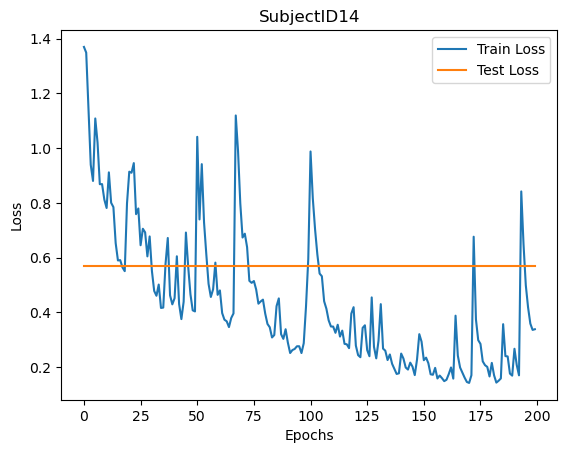

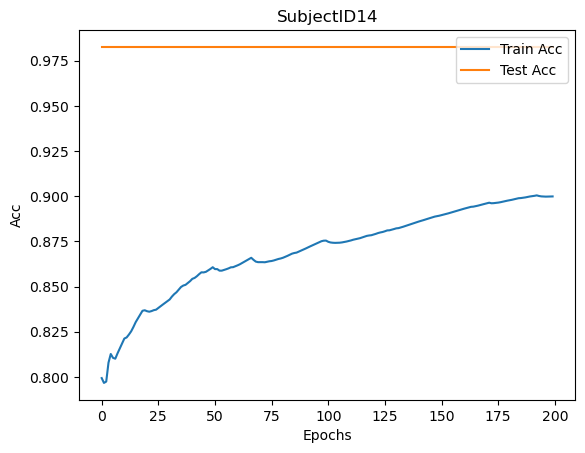


Subject 15
| epoch   0 | 0.4832 s/epoch | train loss 1.2255
| epoch   1 | 0.4839 s/epoch | train loss 0.9827
| epoch   2 | 0.4879 s/epoch | train loss 0.9713
| epoch   3 | 0.4843 s/epoch | train loss 0.8095
| epoch   4 | 0.4849 s/epoch | train loss 0.7673
| epoch   5 | 0.4867 s/epoch | train loss 0.7474
| epoch   6 | 0.4876 s/epoch | train loss 0.8297
| epoch   7 | 0.4864 s/epoch | train loss 0.7419
| epoch   8 | 0.4813 s/epoch | train loss 0.6540
| epoch   9 | 0.4796 s/epoch | train loss 0.6472
| epoch  10 | 0.4827 s/epoch | train loss 0.7597
| epoch  11 | 0.4853 s/epoch | train loss 0.7078
| epoch  12 | 0.4862 s/epoch | train loss 0.7237
| epoch  13 | 0.4869 s/epoch | train loss 0.6521
| epoch  14 | 0.4836 s/epoch | train loss 0.6110
| epoch  15 | 0.4857 s/epoch | train loss 0.5696
| epoch  16 | 0.4857 s/epoch | train loss 0.5478
| epoch  17 | 0.4845 s/epoch | train loss 0.5270
| epoch  18 | 0.4840 s/epoch | train loss 0.5104
| epoch  19 | 0.4820 s/epoch | train loss 0.5223
| epoch 

| epoch 167 | 0.5419 s/epoch | train loss 0.1206
| epoch 168 | 0.5417 s/epoch | train loss 0.1308
| epoch 169 | 0.5420 s/epoch | train loss 0.1391
| epoch 170 | 0.5318 s/epoch | train loss 0.1582
| epoch 171 | 0.5093 s/epoch | train loss 0.1057
| epoch 172 | 0.5108 s/epoch | train loss 0.0948
| epoch 173 | 0.5049 s/epoch | train loss 0.1124
| epoch 174 | 0.5061 s/epoch | train loss 0.1058
| epoch 175 | 0.5085 s/epoch | train loss 0.0893
| epoch 176 | 0.5078 s/epoch | train loss 0.1021
| epoch 177 | 0.5096 s/epoch | train loss 0.1203
| epoch 178 | 0.5093 s/epoch | train loss 0.2019
| epoch 179 | 0.5091 s/epoch | train loss 0.1583
| epoch 180 | 0.5084 s/epoch | train loss 0.1279
| epoch 181 | 0.5098 s/epoch | train loss 0.1416
| epoch 182 | 0.5078 s/epoch | train loss 0.1161
| epoch 183 | 0.5083 s/epoch | train loss 0.1377
| epoch 184 | 0.5080 s/epoch | train loss 0.1148
| epoch 185 | 0.5110 s/epoch | train loss 0.0996
| epoch 186 | 0.5091 s/epoch | train loss 0.0965
| epoch 187 | 0.5073

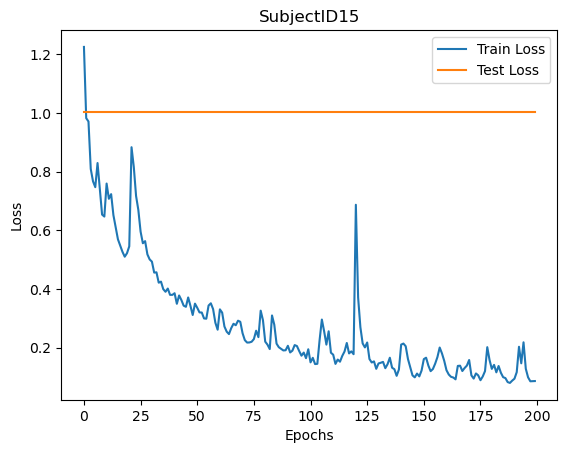

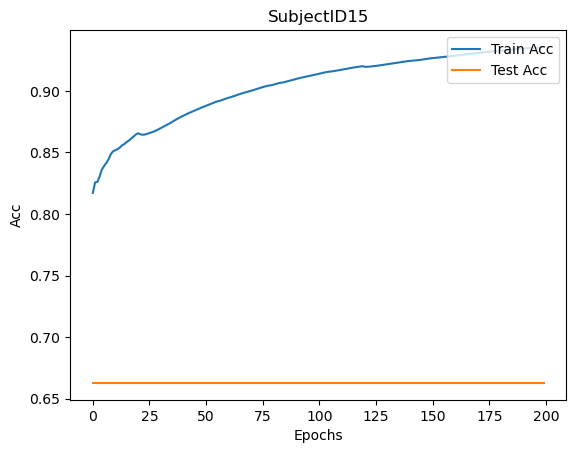

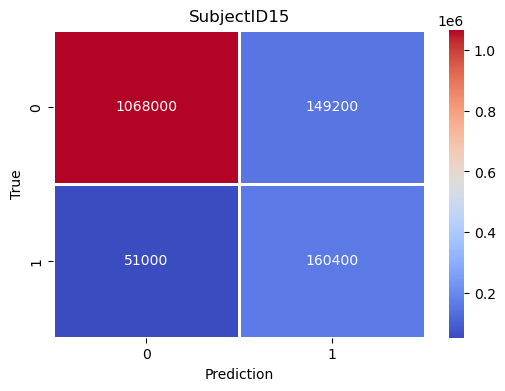

Distillation_Student(RestNet50)_Acc: 0.8598628027439451
Distillation_Student(RestNet50)_Rec: 0.7587511825922422
Distillation_Student(RestNet50)_Pre: 0.5180878552971576
Distillation_Student(RestNet50)_F1: 0.6157389635316698


<Figure size 640x480 with 0 Axes>

In [12]:
teacher_student_train_preds = []
teacher_student_train_gt = []

for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i], axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i], axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i], axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i], axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)
        

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode
    
    
    ResNet_TS = Net_Teacher_Student(block, [3, 4, 23, 3], 1, 2)
    model_teacher_student = ResNet_TS.to(device)
    #model_teacher_student = Net_Teacher_Student(config).to(device) 
    model_teacher_student.train() 
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher_student = torch.optim.Adam(model_teacher_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Establishing Teacher-Student Model
    alpha = 0.5
    training_teacher_student(trainloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student,alpha,testloader)
    #testing_teacher_student(testloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student)
    
    
show_CM_teacher_student(teacher_student_train_preds, teacher_student_train_gt)
teacher_Student_eval_table = evaluation(teacher_student_train_preds, teacher_student_train_gt)    

print("Distillation_Student(RestNet50)_Acc:",teacher_Student_eval_table[0])
print("Distillation_Student(RestNet50)_Rec:",teacher_Student_eval_table[1])
print("Distillation_Student(RestNet50)_Pre:",teacher_Student_eval_table[2])
print("Distillation_Student(RestNet50)_F1:",teacher_Student_eval_table[3])


In [13]:
# print("Teacher(RestNet18)_Acc:",sum(Accuracy_teacher)/14)
# print("Teacher(RestNet18)_Rec:",sum(Recall_teacher)/11)
# print("Teacher(RestNet18)_Pre:",sum(Precision_teacher)/11)
# print("Teacher(RestNet18)_F1:",sum(F1score_teacher)/11)

# print("Original_Student(RestNet18)_Acc:",sum(Accuracy_student)/14)
# print("Original_Student(RestNet18)_Rec:",sum(Recall_student)/11)
# print("Original_Student(RestNet18)_Pre:",sum(Precision_student)/11)
# print("Original_Student(RestNet18)_F1:",sum(F1score_student)/11)

# print("Distillation_Student(RestNet18)_Acc:",sum(Accuracy_teacher_student)/14)
# print("Distillation_Student(RestNet18)_Rec:",sum(Recall_teacher_student)/11)
# print("Distillation_Student(RestNet18)_Pre:",sum(Precision_teacher_student)/11)
# print("Distillation_Student(RestNet18)_F1:",sum(F1score_teacher_student)/11)

dummy_input = torch.randn(64,1,14,3,device=device)
flops_teacher, params_teachar = profile(model_teacher,(dummy_input,))
print('\n\nflops_teacher: %.3f M, params_teachar: %.3f M' % (flops_teacher / 1000000.0, params_teachar / 1000000.0))
flops_student, params_student = profile(model_student,(dummy_input,))
print('flops_student: %.3f M, params_student: %.3f M' % (flops_student / 1000000.0, params_student / 1000000.0))
flops_teacher_student, params_teacher_student = profile(model_teacher_student,(dummy_input,))
print('flops_teacher_student: %.3f M, params_teacher_student: %.3f M' % (flops_teacher_student / 1000000.0, params_teacher_student / 1000000.0))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


flops_teacher: 4743.021 M, params_teachar: 42.495 M
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.